In [1]:
import matplotlib as mpl
from numpy.random import randint

import traceback
from matplotlib.pyplot import *
import matplotlib
import os
import bregnn.io as io
#import bregnn.utils as utils
import sys
import json
from optparse import OptionParser, make_option
sys.path.insert(0, '/users/nchernya/HHbbgg_ETH/bregression/python/')
import datetime
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import probfit
import iminuit
from scipy.stats import norm

from probfit import UnbinnedLH,Normalized,BinnedLH,crystalball
from probfit import gaussian
from iminuit import Minuit


In [5]:
data=io.read_data("/scratch/mdonega/ntuples_NN/Ntup_10Nov_Photon_training.hd5",columns=None)
data=data[data['pt']<300]
data.to_hdf("/t3home/kaechb/ntuples/EB.hd5",key='df',format='table', mode='w')

Opening /scratch/mdonega/ntuples_NN/Ntup_10Nov_Photon_training.hd5 in read-only mode


NN_EE.hd5
NN.hd5
('data read: ', 'EE')
('columns: ', Index([u'response', u'resolution', u'scIsEB', u'genEnergy', u'scRawEnergy',
       u'scEtaWidth', u'scPhiWidth', u'full5x5_e5x5', u'hadronicOverEm',
       u'rhoValue', u'delEtaSeed', u'delPhiSeed', u'full5x5_sigmaIetaIeta',
       u'full5x5_sigmaIetaIphi', u'full5x5_sigmaIphiIphi', u'full5x5_eMax',
       u'full5x5_e2nd', u'full5x5_eTop', u'full5x5_eBottom', u'full5x5_eLeft',
       u'full5x5_eRight', u'full5x5_e2x5Max', u'full5x5_e2x5Left',
       u'full5x5_e2x5Right', u'full5x5_e2x5Top', u'full5x5_e2x5Bottom',
       u'N_SATURATEDXTALS', u'N_ECALClusters', u'clusterRawEnergy_0',
       u'clusterRawEnergy_1', u'clusterRawEnergy_2', u'clusterDPhiToSeed_0',
       u'clusterDPhiToSeed_1', u'clusterDPhiToSeed_2', u'clusterDEtaToSeed_0',
       u'clusterDEtaToSeed_1', u'clusterDEtaToSeed_2', u'iEtaMod5_int',
       u'iPhiMod2_int', u'iEtaMod20_int', u'iPhiMod20_int',
       u'iEtaCoordinate_int', u'iPhiCoordinate_int', u'scPreshowerEner

KeyError: 'response_NN_EE'

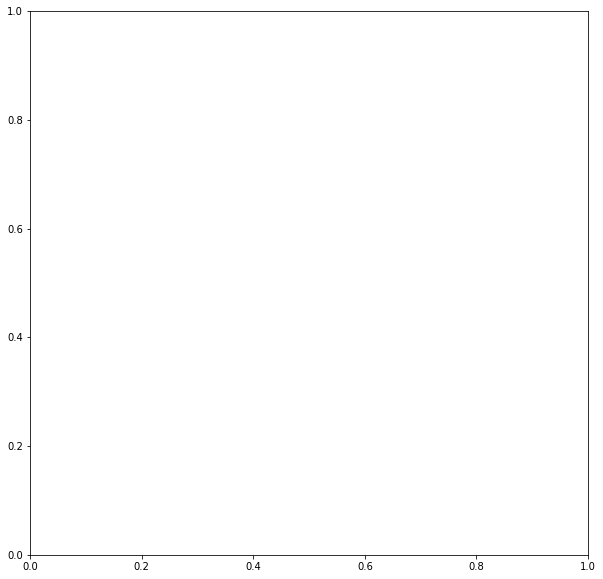

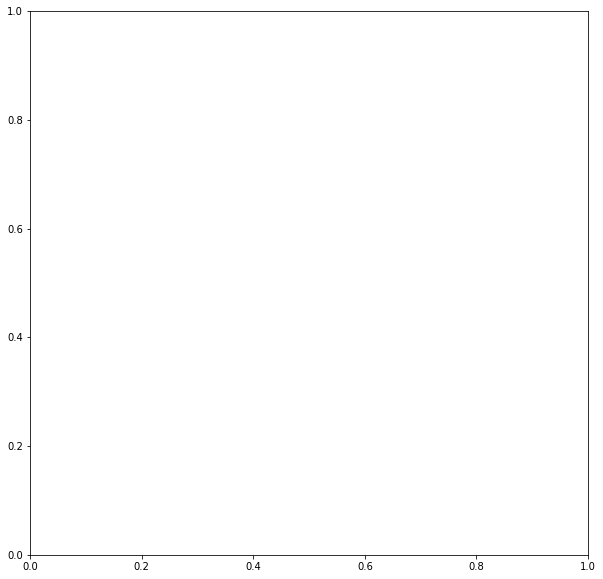

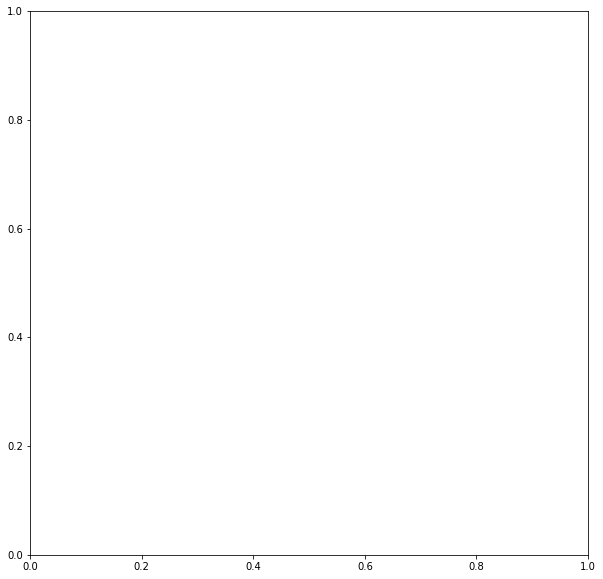

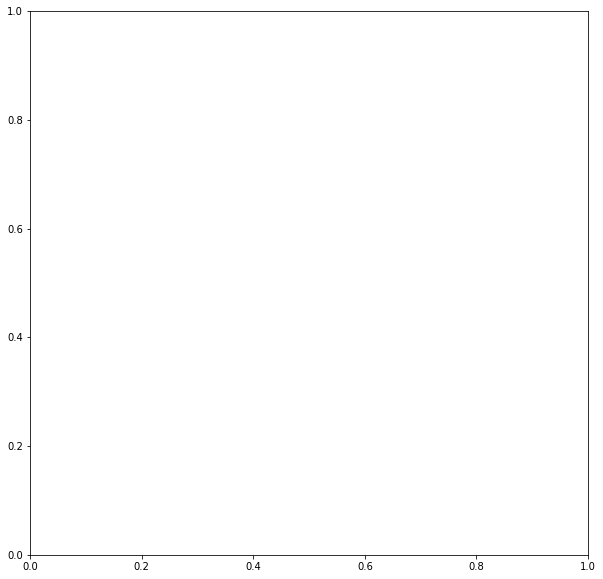

In [83]:

def plot_response(inp_dir,names,out_dir):

    matplotlib.rcParams['figure.figsize'] = [10, 10]
    fig1_no_Tail,ax1_no_Tail=plt.subplots()
    cycol = cycle('bgrcmk')
    fig3_no_Tail,ax3_no_Tail=plt.subplots()
    fig1_Tail,ax1_tail=plt.subplots()
    fig3_Tail,ax3_tail=plt.subplots()
    counter=0
    for i in range(0,len(names)):
        end=names[i].split("_")[-1]
        if sys.argv[1]=="EE"
                fig1=fig1_Tail
                ax1=ax1_tail
                fig3=fig3_Tail
                ax3=ax3_tail
                tag="EE"
        inp_file=names[i]
        data = io.read_data('%s%s'%(inp_dir,inp_file),columns=None)
        print("data read: ",end)
        print("columns: ",df.columns)
        y = (data['genPt']/data['pt']).values.reshape(-1,1)
        X_pt = (data['pt']).values.reshape(-1,1)
        X_eta = (data['scEta']).values.reshape(-1,1)
        response = (data['scRawEnergy']*data['response']).values.reshape(-1,1)
        response_NN = (data['scRawEnergy']*data['response_NN_'+end]).values.reshape(-1,1)
        gen_energy = (data['genEnergy']).values.reshape(-1,1)
        raw_energy = (data['scRawEnergy']).values.reshape(-1,1)
        raw=(data['scRawEnergy']/data['genEnergy']).values.reshape(-1,1)
        ax1.hist(response_NN,bins=100,label="response"+end+lbl+ind,range=(0,20000),density=True,histtype=u'step')
        if counter==0:
            ax3_no_Tail.hist(raw,bins=1000,label='raw',range=(0.8,1.2),histtype=u'step')
            ax3_tail.hist(raw,bins=1000,label='raw',range=(0.8,1.2),histtype=u'step')
            counter+=1
        ax3.hist(gen_energy/response_NN,bins=1000,range=(0.8,1.2),
                 log=False,label='corrected_'+end,histtype=u'step');

    ax3_no_Tail.legend(loc='upper right');
    ax1_no_Tail.legend(loc='upper right')
    ax1_no_Tail.set_title("histogramm scRawEnergy*response  Huber pt")
    ax3_no_Tail.set_title("Histogram gen_energy/response Huber pt ")
    fig1_no_Tail.show()
    fig3_no_Tail.show()
    fig3_no_Tail.savefig("{}/historical_comparision".format(out_dir))
    fig1_no_Tail.savefig("{}/response".format(out_dir))
    ax3_tail.legend(loc='upper right');
    ax1_tail.legend(loc='upper right')
    ax1_tail.set_title("histogramm scRawEnergy*response  HuberOneTail pt")
    ax3_tail.set_title("Histogram gen_energy/response HuberOneTail pt")
    fig1_Tail.show()
    fig3_Tail.show()
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
from probfit.pdf import doublecrystalball,doublegaussian
from probfit.plotting import draw_normed_pdf
from itertools import cycle
InteractiveShell.ast_node_interactivity = "last_expr"

parent_dir="/t3home/kaechb/ntuples/"
tag=sys.argv[1]
names=[]      
for file in os.listdir(parent_dir):
    print(file)
#for file in os.listdir(sys.argv[1]):
    if file.find('.hd')!=-1 and file != "NN_EE.hd5" and file !='NN.hd5':
        names.append(file)
out_dir="/t3home/kaechb/Temp"
plot_response(parent_dir,names,out_dir)













bins_gaussian_amount=100
bins_double_gaussian_amount=20
amountbins_column=15
end='HuberLoss'
lbl='delta'
debug_fit=0
plot_out_dir="/t3home/kaechb/HuberLossApply2/"
debug_fit_gauss=0
for column in ['pt','scEta','rhoValue']:#

    profile_x=[]
    profile_y=[]
    profile_ef=[]
    profile_down=[]
    profile_up=[]
    profile_sigma_l=[]

    for k in range(0,len(names)):
        if k<len(names):
            inp_dir=parent_dir
            inp_file=names[k]
            if names[k].find("OneTail")>0:

                    end="HuberLossOneTail"
                    lbl="delta"+names[k][21]
                    color='r'
                    color2='y'
            elif names[k].find("Huber")>0:
                    end="HuberLoss"
                    lbl="delta"+names[k][14]
                    color='b'
                    color2='m'
        else:
            end="BDT"
            lbl="BDT"
        original_df=io.read_data('%s%s'%(inp_dir,inp_file),columns=None)
        print('%s%s'%(inp_dir,inp_file))

        lower_bound=0.9
        upper_bound=1.1

        y_plot=np.zeros(amountbins)
        x_plot=np.zeros(amountbins)
        y_err_fit=np.zeros(amountbins)
        sigma_l=np.zeros(amountbins)
        y_err_L_sigma=np.zeros(amountbins)
        y_err_R_sigma=np.zeros(amountbins)
        df=original_df.copy()

            
        df.loc[:,'response']=np.reciprocal(df.loc[:,'response'].values)
        df=df[df['response']>lower_bound]
        df=df[df['response']<upper_bound]
        if k<len(names):
            df.loc[:,'response_NN_'+end]=np.reciprocal(df.loc[:,'response_NN_'+end].values)
            df=df[df['response_NN_'+end]>lower_bound]
            df=df[df['response_NN_'+end]<upper_bound]
        df=df[df['pt']>0]
        df=df[df['pt']<300]
#        df.loc[:,column[:2]]=df[abs(df[column[:2]]-df[column[:2]].mean())<3*df[column[:2]].std()][column[:2]] #outlier fuck up binning otherwise
        notused,bins=pd.qcut(df[column],amountbins_column, retbins=True)   

        for i in range(0,len(bins)-1):
            try:
                ##selecting data in bin
                df_temp=df[df[column] >=bins[i]]

                df_temp=df_temp[df_temp[column]<=bins[i+1]]
                if k<len(names):
                    data=df_temp.loc[:,'response_NN_'+end].astype(float).values

                else:
                    data=df_temp.loc[:,'response'].astype(float).values 


                n,bins_gauss,patches=plt.hist(data,bins=bins_gaussian_amount,density=True)
                plt.close()
                if np.sum(n) ==0:
                    print("sum is zero!")
                    continue
                n_max=np.argmax(n)
                print("max n:{} at {}".format(np.max(n),bins_gauss[n_max]))
                bound_gauss=[bins_gauss[n_max-2],bins_gauss[n_max+3]]#centered around the max
                normalized_gaussian = probfit.Normalized(probfit.gaussian, bound_gauss)
                normalized_doublegaussian = probfit.Normalized(probfit.pdf.doublegaussian, bound_gauss)
                binned_likelihood_gauss = probfit.BinnedLH(normalized_gaussian, data, 
                                         bins=bins_double_gaussian_amount, bound=bound_gauss)

                pars_gauss = dict(mean  = bins_gauss[np.argmax(n)],
                                  sigma = 0.05,
                                   )
                minuit = iminuit.Minuit(binned_likelihood_gauss,print_level=debug_fit_gauss, **pars_gauss)
                minuit.migrad()  
                binned_likelihood_gauss.draw(minuit,nfbins=bins_double_gaussian_amount)
                plt.close()




                mean_gauss  = minuit.values[0]
                sigma_gauss = minuit.values[1]
                if sigma_gauss==0:
                    sigma_gauss==0.05
                pars_dg = dict(mean  = mean_gauss,  
                               sigma_L = sigma_gauss,
                               sigma_R =sigma_gauss,
                               limit_sigma_L=(0.001,0.1),
                               limit_sigma_R=(0.001,0.3),
                               )
                binned_likelihood_dg   = probfit.BinnedLH(normalized_doublegaussian, data,
                                bins=bins_double_gaussian_amount, bound=bound_gauss)

                minuit = iminuit.Minuit(binned_likelihood_dg,print_level=debug_fit, **pars_dg)
                minuit.migrad( ) 
                binned_likelihood_dg.draw(minuit)
                plt.close()

                pars =dict(minuit.values)

                #pars['limit_mean']=(0.986,1.01)
                minuit = iminuit.Minuit(binned_likelihood_dg,print_level=debug_fit_gauss, **pars)
                minuit.migrad()  
                coeff=minuit.args
                display(coeff)

                ax=plt.subplot2grid((6,3),(0,0), rowspan=4,colspan=4)   
                (data_edges, datay), (errorp, errorm), (total_pdf_x, total_pdf_y),parts = \
                binned_likelihood_dg.draw(minuit,parmloc=((0.1,0.95)),nfbins=10*bins_double_gaussian_amount)

                plt.title("Double Gaussian $response$ for ${}$ in {} to {}".format(column,int(10*bins[i])/10.,int(10*bins[i+1])/10.))
                data_edges=(data_edges[1:]+data_edges[:-1])/2
                fit_y=np.zeros(len(datay))
                x_plot[i]=df_temp[column].values[np.argmin(df_temp['response'].values-coeff[0])]
                y_plot[i]=coeff[0]
                y_err_fit[i]+=minuit.errors[0]
                y_err_L_sigma[i]+=coeff[1]
                sigma_l[i]+=coeff[1]
                y_err_R_sigma[i]+=coeff[2]
                for kill in range(0,len(datay)):
                    fit_y[kill]=total_pdf_y[np.argmin(abs(total_pdf_x - data_edges[kill]))]
                ratio=datay/fit_y
                plt.subplot2grid((5,3),(4,0),rowspan=2,colspan=4).set_yticks([0.8,1])
                plt.plot(data_edges,ratio,'bo')


                plt.ylabel(r"$ratio$")
                plt.xlabel("response")
                plt.ylim([0.8,1.2])
                plt.savefig("/scratch/kaechb/Comparision/old_{}__{}_{}_{}".format(column,i,end,lbl)) 

                plt.show()

            except Exception as e:
                print(traceback.print_exc())
                print ("erroor")
        df=df[df['pt']>0]
        profile_x.append(x_plot)
        profile_y.append(y_plot)
        profile_ef.append(y_err_fit)
        profile_down.append(y_err_L_sigma)
        profile_up.append(y_err_R_sigma)
        profile_sigma_l.append(sigma_l)



    fig,ax=plt.subplots()
    ax.set_ylim([0.95,1.03])
    ax.set_title("Profile $response$ vs ${}$, Fit error".format(column))
    ax.set_ylabel(r"$response$")
    ax.set_xlabel(r"${}$".format(column))
    for index in range(0,len(names)):
   
            if names[index].find("OneTail")>0:

                    end="HuberLossOneTail"
                    lbl="delta"+names[index][21]
                    end=end+lbl

            elif names[index].find("Huber")>0:
                    end="HuberLoss"
                    lbl="delta"+names[index][14]
                    end=end+lbl
            ax.errorbar(profile_x[index],profile_y[index],yerr=profile_ef[index],fmt='.',label=end)  
    ax.legend()
    fig.savefig(plot_out_dir+"Fit_Error_{}response_vs_{}".format(end,column))
    fig.show()
    
    fig,ax=plt.subplots()

    ax.set_title("Profile $\sigma_L$ vs ${}$".format(column))
    ax.set_ylabel(r"$response$")
    ax.set_xlabel(r"${}$".format(column))
    for index in range(0,len(names)):
#         if index==len(names)+1:
#             end="BDT"

#         else:
        if names[index].find("OneTail")>0:

                end="HuberLossOneTail"
                lbl="delta"+names[index][21]
                end=end+lbl

        elif names[index].find("Huber")>0:
                end="HuberLoss"
                lbl="delta"+names[index][14]
                end=end+lbl
        ax.errorbar(profile_x[index],profile_sigma_l[index],fmt='.',label="sigma"+end)  
    ax.legend()
    fig.savefig(plot_out_dir+"Sigma_L_{}response_vs_{}".format(end,column))
    fig.show()




In [66]:
def plot_response(input_dir,names,out_dir):
   
        matplotlib.rcParams['figure.figsize'] = [10, 10]
        fig,ax=plt.subplots()
        fig1,ax1=plt.subplots()
        cycol = cycle('bgrcmk')
        counter=0
        for i in range(0,len(names)):
            print(names[i])
            if names[i].find("EE")>-1:
                tag='EE'
            if names[i].find("EB")>-1:
                tag='EB'
            if names[i].find("OneTail")>-1:
                    end="HuberLossOneTail"

            elif names[i].find("mse")>-1:
                    end="mse"
            elif names[i].find("HuberLoss_")>-1:
                end='HuberLoss'
                  

            inp_dir=input_dir
            inp_file=names[i]

            data = io.read_data('%s%s'%(inp_dir,inp_file),columns=None)




            print("data read: ",end)
            y = (data['genPt']/data['pt']).values.reshape(-1,1)
            X_pt = (data['pt']).values.reshape(-1,1)
            X_eta = (data['scEta']).values.reshape(-1,1)
            response = (data['scRawEnergy']*data['response']).values.reshape(-1,1)
            response_NN = (data['scRawEnergy']*data['response_NN_'+end]).values.reshape(-1,1)
            gen_energy = (data['genEnergy']).values.reshape(-1,1)
            raw_energy = (data['scRawEnergy']).values.reshape(-1,1)
            raw=(data['scRawEnergy']/data['genEnergy']).values.reshape(-1,1)
            ax.hist(response_NN,bins=100,label="response"+end,range=(0,5000),density=True,histtype=u'step')
            if counter==0:
                ax1.hist(raw,bins=1000,label='raw',range=(0.8,1.2),histtype=u'step',density=True)
                counter+=1


            ax1.hist(gen_energy/response_NN,bins=1000,range=(0.8,1.2),density=True,
                     log=False,label='corrected_'+end,histtype=u'step');



        ax.legend(loc='upper right');
        ax1.legend(loc='upper right')
        ax.set_title("Normalized Histogramm of scRawEnergy*response  Huber {}".format(tag))
        ax.set_ylabel("%")
        ax.set_xlabel("scRawEnergy*response")
        ax1.set_ylabel("%")
        ax1.set_xlabel("response")
        ax1.set_title("Normalized Histogram of gen_energy/response Huber {}".format(tag))

        fig.savefig("{}/{}_Comparision_Huber_mse_energies.png".format(out_dir,tag))
        fig1.savefig("{}/{}_Comparision_Huber_mse".format(out_dir,tag))
        fig1.show()
        fig.show()

['HuberLoss_1_EE_applied/applied_res_2019-05-02_EE.hd5', 'HuberLossOneTail_1_EE_applied/applied_res_2019-05-02_EE.hd5', 'mse_EE_1_applied/applied_res_2019-05-02_EE.hd5']
HuberLoss_1_EE_applied/applied_res_2019-05-02_EE.hd5
('data read: ', 'HuberLoss')
HuberLossOneTail_1_EE_applied/applied_res_2019-05-02_EE.hd5
('data read: ', 'HuberLossOneTail')
mse_EE_1_applied/applied_res_2019-05-02_EE.hd5
('data read: ', 'mse')


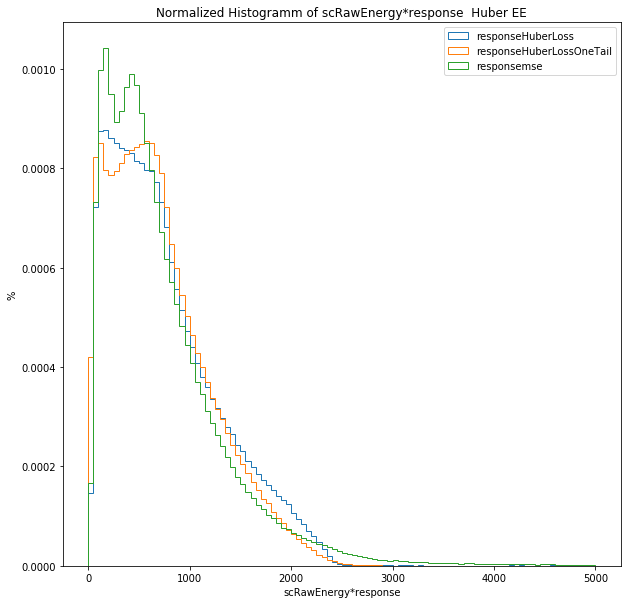

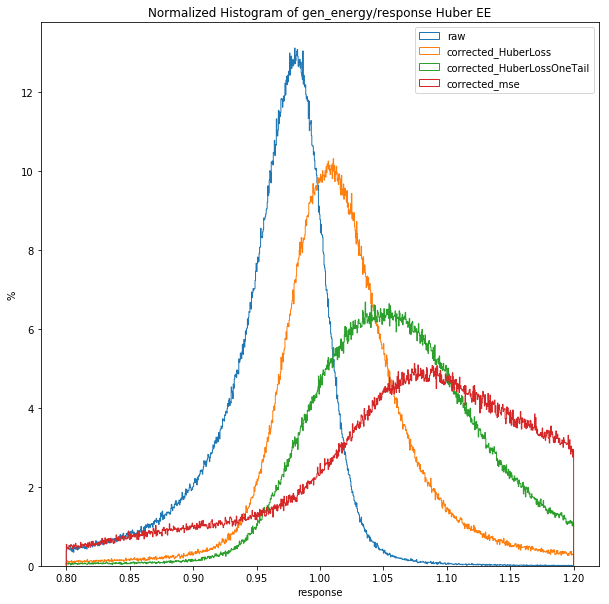

In [67]:
import os

from IPython.core.interactiveshell import InteractiveShell
from probfit.pdf import doublecrystalball,doublegaussian
from probfit.plotting import draw_normed_pdf
from itertools import cycle
InteractiveShell.ast_node_interactivity = "last_expr"
input_dir=[]
names=[]
parent_dir="/work/kaechb/applied_EE/"
for dire in os.listdir(parent_dir):
      
    #if  os.path.isdir("/work/kaechb/"+dire):
        for file in os.listdir(parent_dir+dire):#+"/"+dire
        #for file in os.listdir(sys.argv[1]):
            if file.find('.hd')!=-1 and file.find('applied')!=-1 and dire.find('1')!=-1:
               # input_dir.append(parent_dir)#+dire+"/"][0]
                
                names.append(dire+"/"+file)
print(names)
plot_response(parent_dir,names,"/work/kaechb/plots/")


/work/kaechb/applied_EB/HuberLossOneTail_2_EB_applied/applied_res_2019-05-02_EB.hd5
HuberLossOneTail
max n:27.2092686278 at 0.982814993858


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:99: SmallIntegralWarning: (0.9828149938583374, -0.04058539729619848)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: In

<ArgsView of Minuit at 55873d227050>
  0.984060756607
  0.0106826232577
  0.0054354232328

[0.00619529 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]


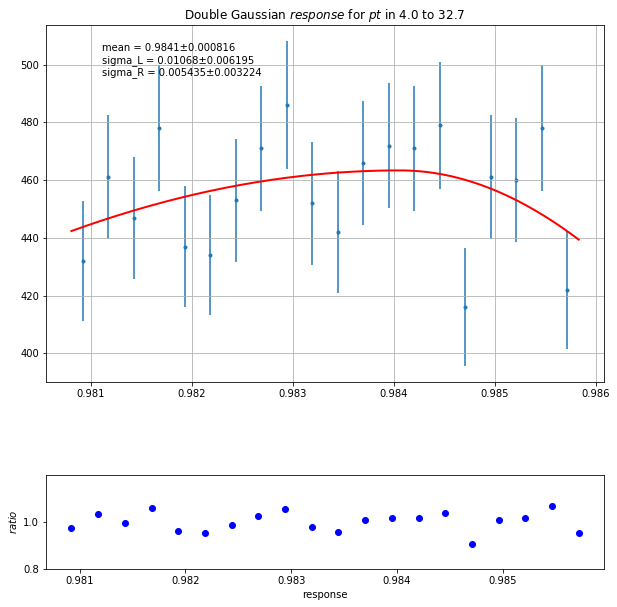

max n:34.6278666471 at 0.994109117985


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:99: SmallIntegralWarning: (0.9941091179847718, -0.01077754580767485)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: In

<ArgsView of Minuit at 55873ce42570>
  0.994589879589
  0.005550385942
  0.00294351690111

[0.00619529 0.00135265 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]


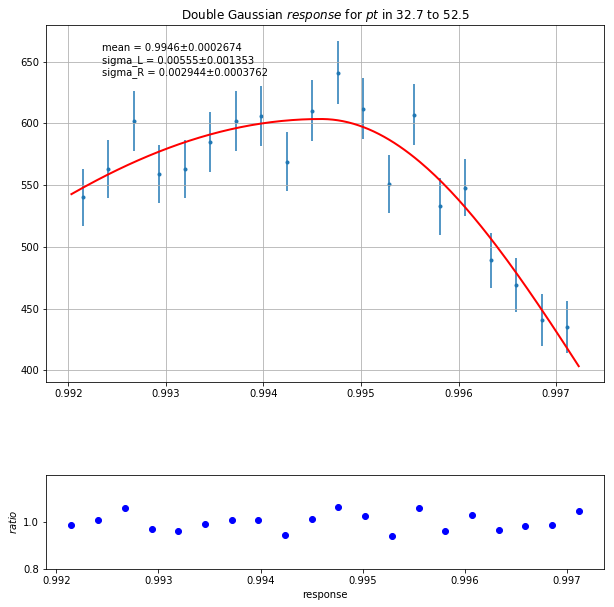

max n:51.537282261 at 0.996643003821


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:99: SmallIntegralWarning: (0.9966430038213729, -0.01182000654874802)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: In

<ArgsView of Minuit at 55873d1b1760>
  0.99738950045
  0.00390259393621
  0.00319864200763

[0.00619529 0.00135265 0.00044409 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]


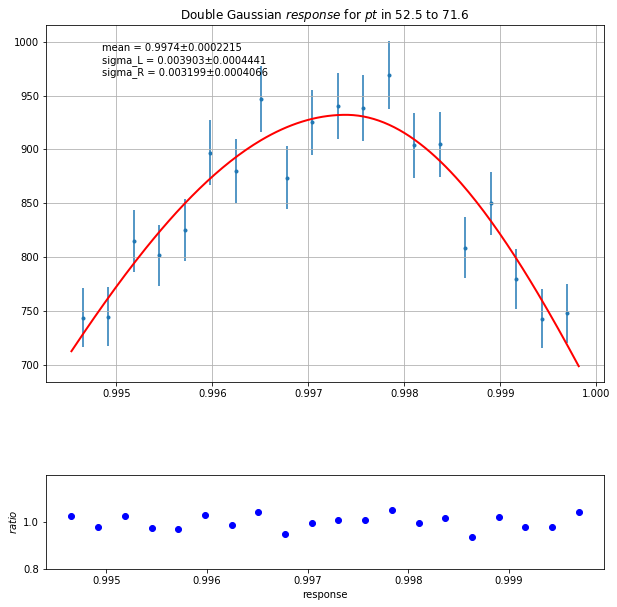

max n:73.7010995405 at 0.998474802971


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:99: SmallIntegralWarning: (0.9984748029708862, -0.02807519897157197)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: In

<ArgsView of Minuit at 55873cdbdc40>
  0.999501750231
  0.00346262060082
  0.00250365649679

[0.00619529 0.00135265 0.00044409 0.00022817 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]


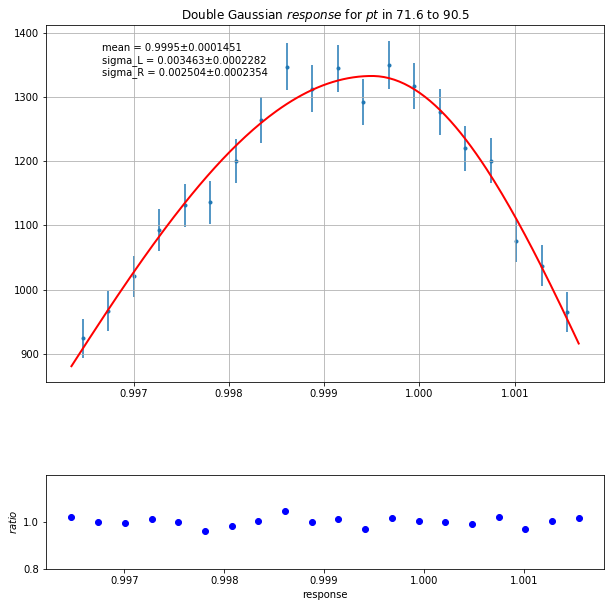

max n:97.9680053115 at 1.00031151056


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:99: SmallIntegralWarning: (1.0003115105628968, -0.02592741620083623)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: In

<ArgsView of Minuit at 55873cdb8080>
  1.00055660982
  0.00273687426446
  0.00241393849269

[0.00619529 0.00135265 0.00044409 0.00022817 0.00017351 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]


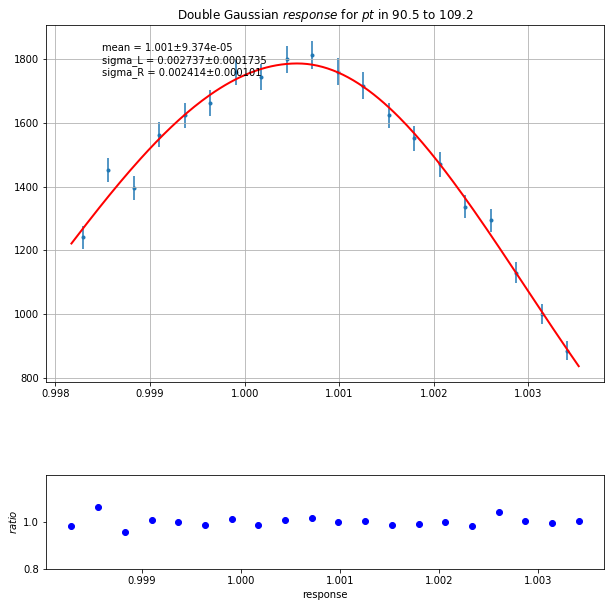

max n:119.074637705 at 1.00086038828


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:99: SmallIntegralWarning: (1.0008603882789613, -0.036604474955626534)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: I

<ArgsView of Minuit at 55873e4cea90>
  1.00133105138
  0.00253648164107
  0.00195128946837

[0.00619529 0.00135265 0.00044409 0.00022817 0.00017351 0.00010213
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]


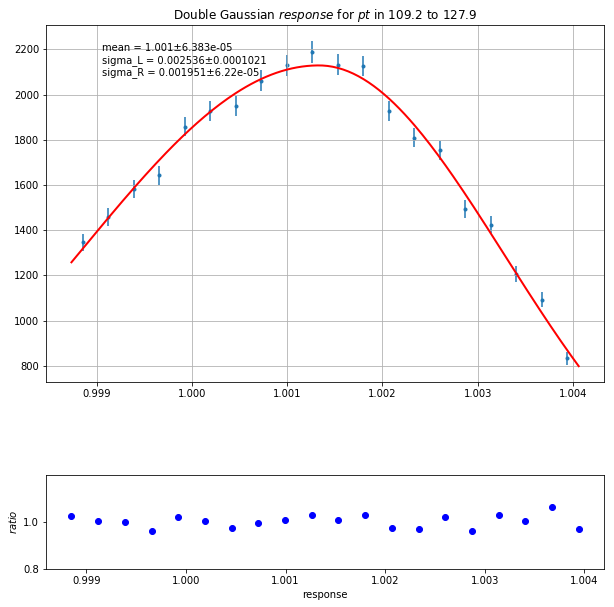

max n:127.598787023 at 1.00088479519


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:99: SmallIntegralWarning: (1.0008847951889037, -0.04559897420124069)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: In

<ArgsView of Minuit at 55873e63ce20>
  1.00181844461
  0.00265080331571
  0.0016409265812

[6.19528752e-03 1.35264590e-03 4.44092036e-04 2.28168349e-04
 1.73514616e-04 1.02129823e-04 7.09258013e-05 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00]


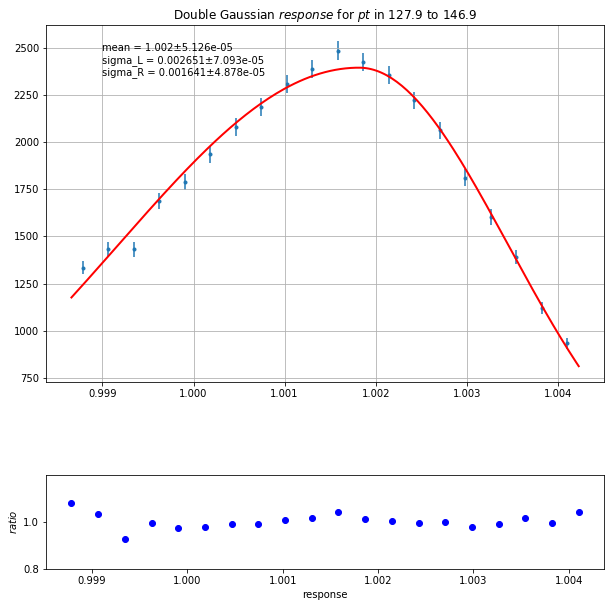

max n:131.61588116 at 1.0010567677


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:99: SmallIntegralWarning: (1.0010567677021027, -0.06050513560752886)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: In

<ArgsView of Minuit at 55873d3f3d20>
  1.00181155402
  0.00258384565172
  0.00161839272169

[6.19528752e-03 1.35264590e-03 4.44092036e-04 2.28168349e-04
 1.73514616e-04 1.02129823e-04 7.09258013e-05 6.75349761e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00]


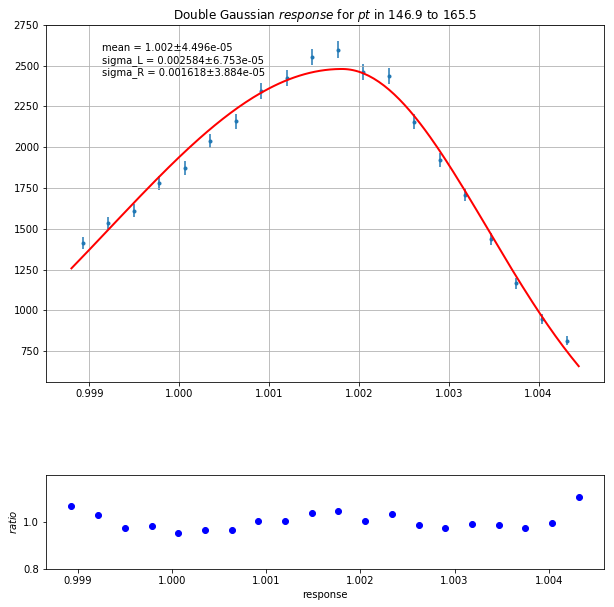

max n:131.102277721 at 1.00097250581


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:99: SmallIntegralWarning: (1.0009725058078767, -0.05965996277110526)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: In

<ArgsView of Minuit at 55873eb5d690>
  1.0013757221
  0.00243279045987
  0.00185989641909

[6.19528752e-03 1.35264590e-03 4.44092036e-04 2.28168349e-04
 1.73514616e-04 1.02129823e-04 7.09258013e-05 6.75349761e-05
 6.07362832e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00]


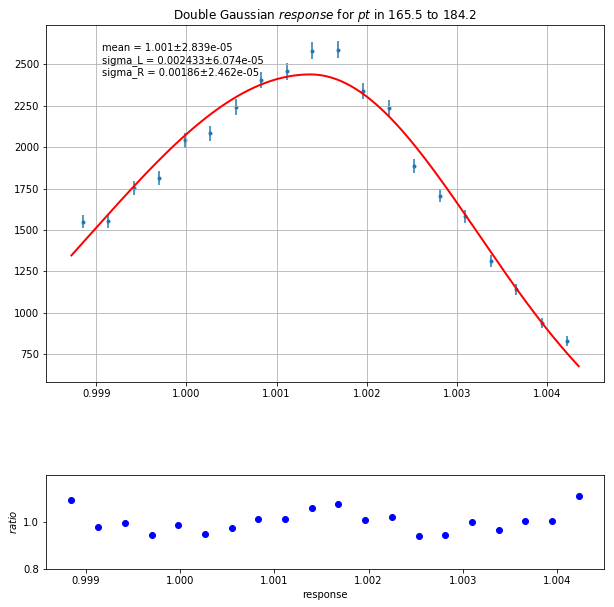

max n:123.303170997 at 1.00055587053


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:99: SmallIntegralWarning: (1.0005558705329896, -0.03579315310571962)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: In

<ArgsView of Minuit at 55873d406030>
  1.00134637033
  0.00292158361495
  0.00187692943064

[6.19528752e-03 1.35264590e-03 4.44092036e-04 2.28168349e-04
 1.73514616e-04 1.02129823e-04 7.09258013e-05 6.75349761e-05
 6.07362832e-05 7.46919820e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00]


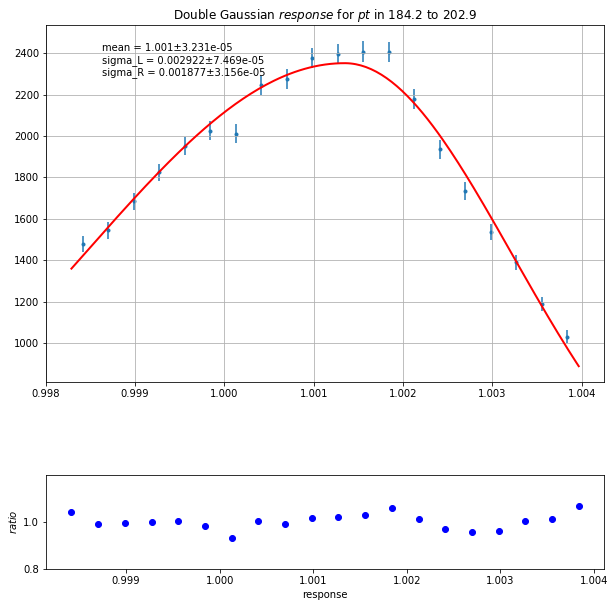

max n:116.983751872 at 1.00079613328


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:99: SmallIntegralWarning: (1.0007961332798003, -0.026342655054498273)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: I

<ArgsView of Minuit at 55873d2070f0>
  1.00124131912
  0.00325314388127
  0.00225453144143

[6.19528752e-03 1.35264590e-03 4.44092036e-04 2.28168349e-04
 1.73514616e-04 1.02129823e-04 7.09258013e-05 6.75349761e-05
 6.07362832e-05 7.46919820e-05 1.35172003e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00]


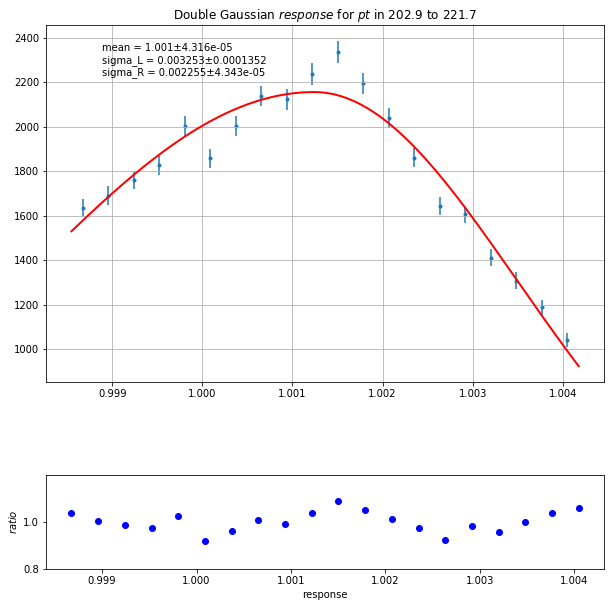

max n:108.124998375 at 1.00055453062


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:99: SmallIntegralWarning: (1.000554530620575, -0.02043912891571291)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: Ini

<ArgsView of Minuit at 55873d501f10>
  1.00162518589
  0.0039067364418
  0.00229742029563

[6.19528752e-03 1.35264590e-03 4.44092036e-04 2.28168349e-04
 1.73514616e-04 1.02129823e-04 7.09258013e-05 6.75349761e-05
 6.07362832e-05 7.46919820e-05 1.35172003e-04 1.48424130e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00]


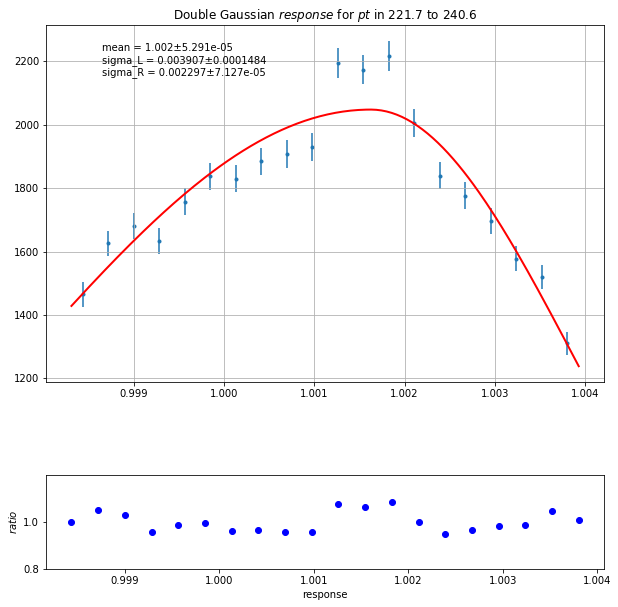

max n:108.026041404 at 1.00113111734


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:99: SmallIntegralWarning: (1.0011311173439026, -0.013345332706761068)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: I

<ArgsView of Minuit at 55873d521aa0>
  1.00205205404
  0.0041672823435
  0.00244705403011

[6.19528752e-03 1.35264590e-03 4.44092036e-04 2.28168349e-04
 1.73514616e-04 1.02129823e-04 7.09258013e-05 6.75349761e-05
 6.07362832e-05 7.46919820e-05 1.35172003e-04 1.48424130e-04
 1.96560168e-04 0.00000000e+00 0.00000000e+00]


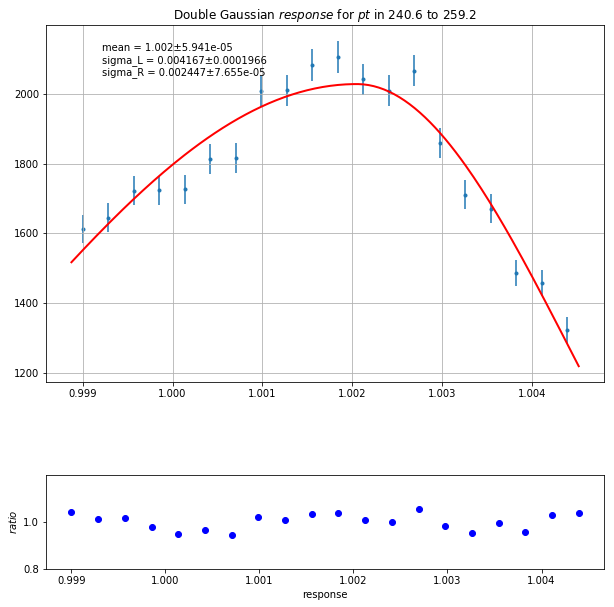

max n:112.45732076 at 1.00155172586


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:99: SmallIntegralWarning: (1.0015517258644104, -0.01855511435147325)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: In

<ArgsView of Minuit at 55873d3b3d90>
  1.00245194257
  0.00377131264601
  0.00228128191029

[6.19528752e-03 1.35264590e-03 4.44092036e-04 2.28168349e-04
 1.73514616e-04 1.02129823e-04 7.09258013e-05 6.75349761e-05
 6.07362832e-05 7.46919820e-05 1.35172003e-04 1.48424130e-04
 1.96560168e-04 1.50145700e-04 0.00000000e+00]


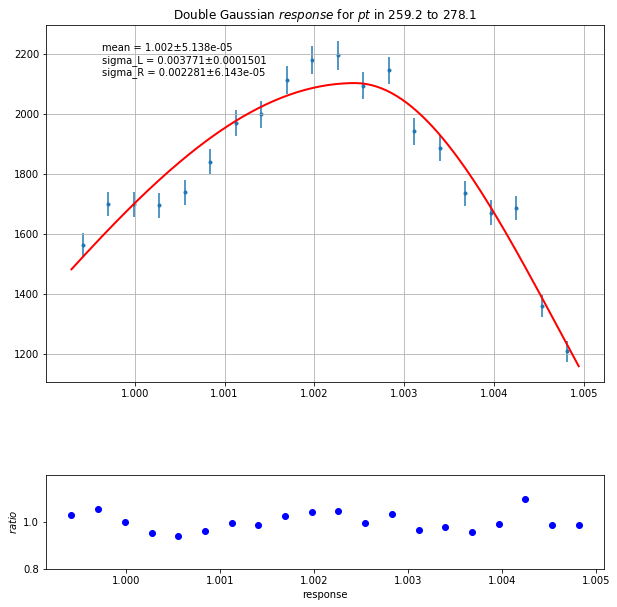

max n:110.935869856 at 1.00244995952


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:99: SmallIntegralWarning: (1.0024499595165253, -0.027177861581145213)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: I

<ArgsView of Minuit at 55873cdfded0>
  1.00271363291
  0.00326933102434
  0.00234388814232

[6.19528752e-03 1.35264590e-03 4.44092036e-04 2.28168349e-04
 1.73514616e-04 1.02129823e-04 7.09258013e-05 6.75349761e-05
 6.07362832e-05 7.46919820e-05 1.35172003e-04 1.48424130e-04
 1.96560168e-04 1.50145700e-04 2.20497333e-04]


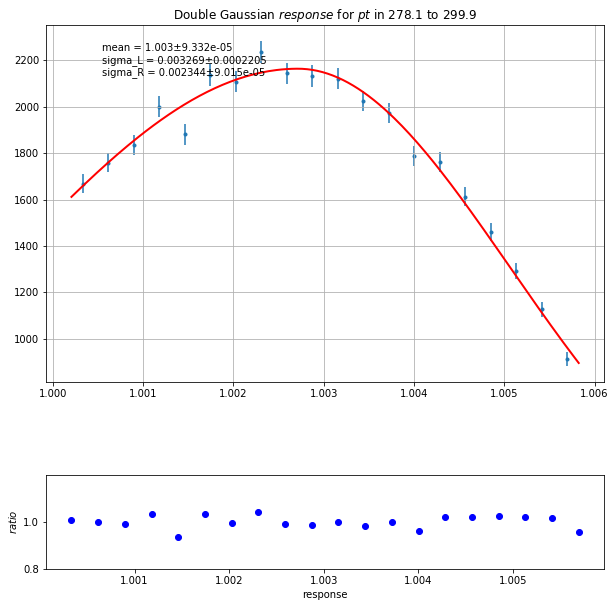

/work/kaechb/applied_EB/HuberLossOneTail_5_EB_applied/applied_res_2019-05-02_EB.hd5
HuberLossOneTail
max n:37.0448132658 at 0.991245859861


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:99: SmallIntegralWarning: (0.9912458598613739, -0.039083972892746274)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: I

<ArgsView of Minuit at 55873e51f050>
  0.991935196251
  0.00437448632429
  0.00655798578909

[0.00095267 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]


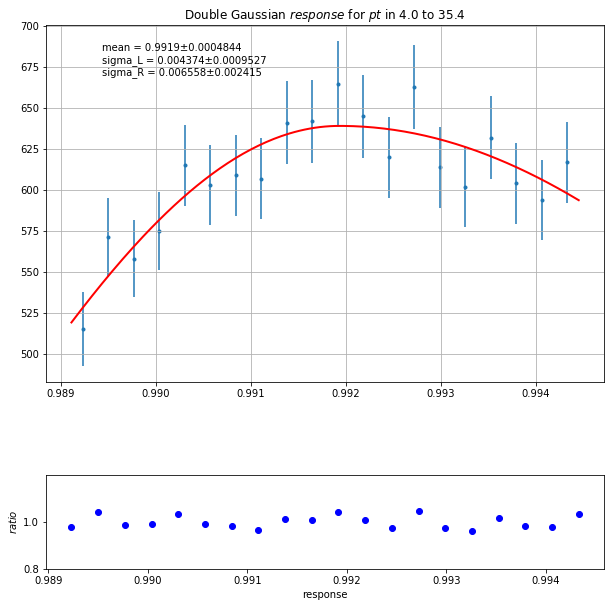

max n:43.8750086253 at 0.997495430708


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:99: SmallIntegralWarning: (1591.9562944766965, -323.625573249856)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: Initi

<ArgsView of Minuit at 55873eec4830>
  0.998133173552
  0.00633509494906
  0.00539700034197

[0.00095267 0.00209186 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]


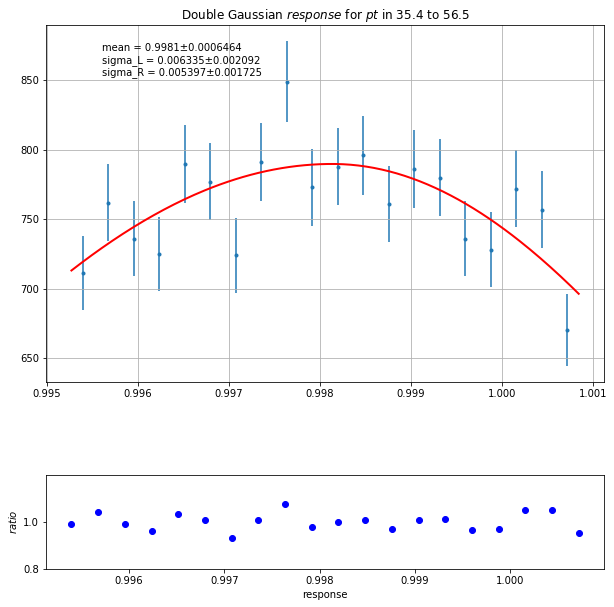

max n:60.1804907345 at 1.00326674283


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:99: SmallIntegralWarning: (1.0032667428255082, -0.02458526461770147)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: In

<ArgsView of Minuit at 55873d520a60>
  1.00343404778
  0.00497914232771
  0.00259629433587

[0.00095267 0.00209186 0.00084058 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]


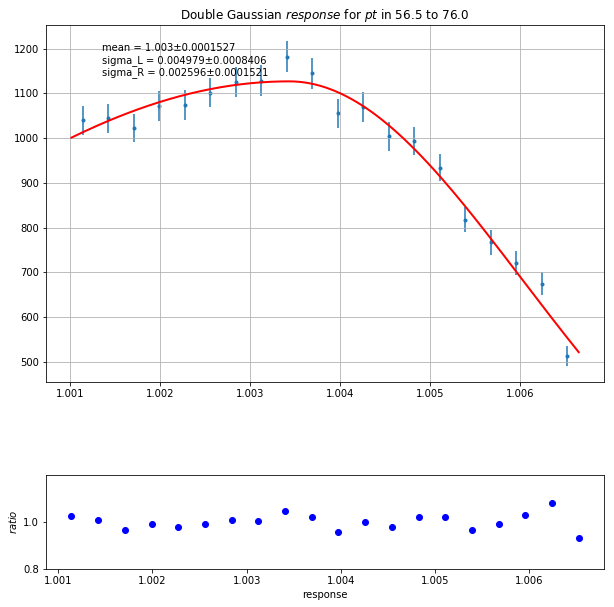

max n:88.0586632724 at 1.0041020453


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:99: SmallIntegralWarning: (1.0041020452976226, -0.04542584582964437)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: In

<ArgsView of Minuit at 55873c9a06f0>
  1.00503478848
  0.00259086798435
  0.00222700109091

[9.52670207e-04 2.09185663e-03 8.40579997e-04 9.07060037e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00]


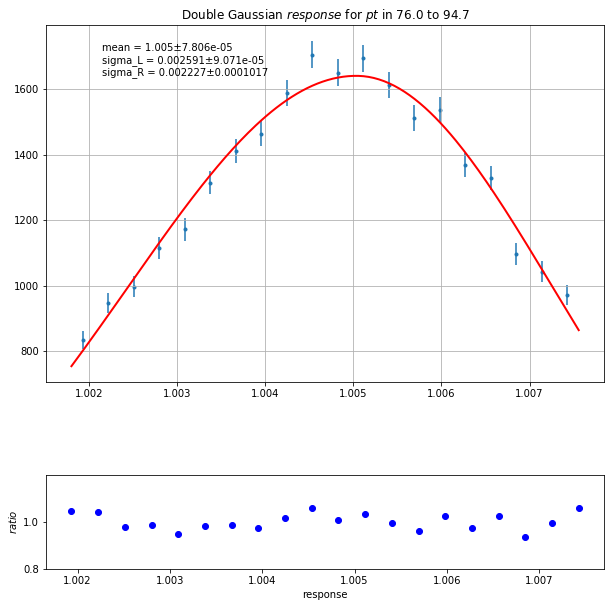

max n:102.846907749 at 1.00527560711


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:99: SmallIntegralWarning: (1.0052756071090698, -0.05398086989882368)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: In

<ArgsView of Minuit at 55873d0ca2c0>
  1.00590367931
  0.00203348240782
  0.00237465500581

[9.52670207e-04 2.09185663e-03 8.40579997e-04 9.07060037e-05
 4.24081306e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00]


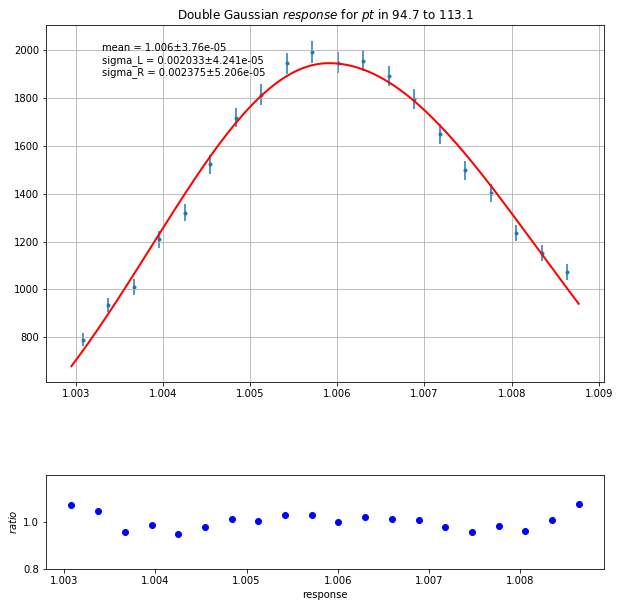

max n:102.516406701 at 1.00595178008


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:99: SmallIntegralWarning: (1.0059517800807953, -0.07676640779006767)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: In

<ArgsView of Minuit at 55873e865140>
  1.00650265357
  0.00181147791401
  0.00277346403976

[9.52670207e-04 2.09185663e-03 8.40579997e-04 9.07060037e-05
 4.24081306e-05 3.54315456e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00]


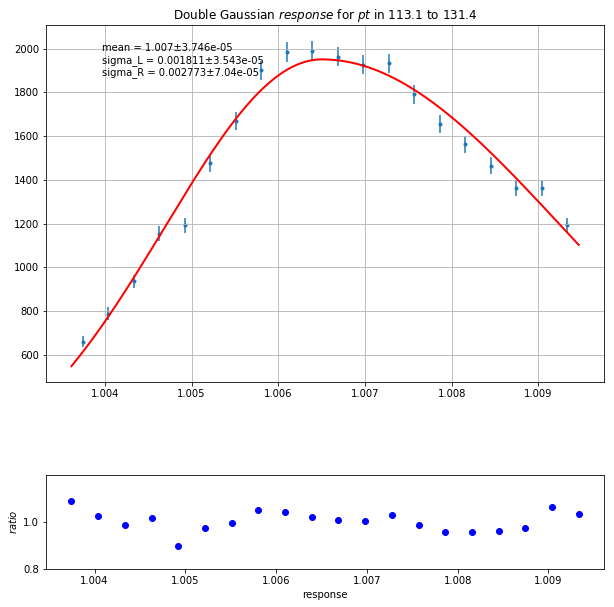

max n:94.5124708762 at 1.006556499


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:99: SmallIntegralWarning: (1.006556499004364, -0.013407317952431552)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: In

<ArgsView of Minuit at 55873eb798c0>
  1.00720401578
  0.00185794854788
  0.00361416455318

[9.52670207e-04 2.09185663e-03 8.40579997e-04 9.07060037e-05
 4.24081306e-05 3.54315456e-05 5.51327185e-05 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00]


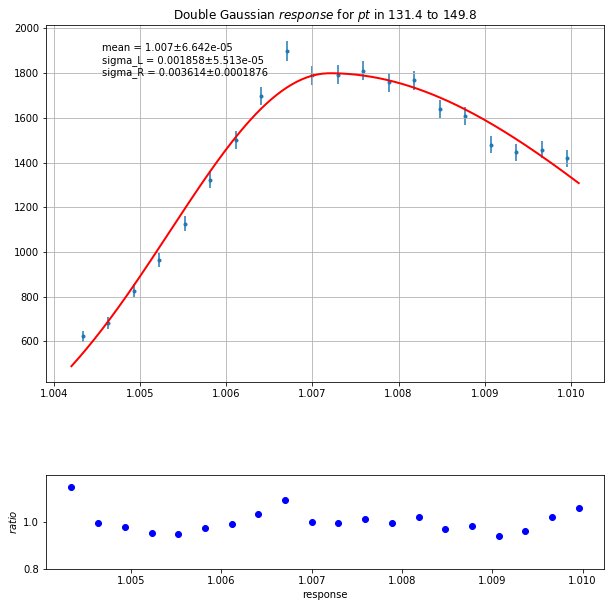

max n:81.2792288437 at 1.00775292516
None
erroor


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:99: SmallIntegralWarning: (1.9739206716685873, -0.15299370402212642)
Traceback (most recent call last):
  File "<ipython-input-8-60aa10f09c99>", line 99, in <module>
    minuit.migrad()
  File "iminuit/_libiminuit.pyx", line 769, in iminuit._libiminuit.Minuit.migrad
RuntimeError: exception was raised in user function
User function arguments:
     mean = +1.810841
    sigma = +0.012480
Original python exception in user function:
ZeroDivisionError: float division by zero
  File "probfit/costfunc.pyx", line 489, in probfit.costfunc.Binne

max n:86.0387312175 at 1.01126336932


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:99: SmallIntegralWarning: (1.0112633693218231, -0.013707402338292957)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: I

<ArgsView of Minuit at 55873e54a1d0>
  1.01125668168
  0.00293509208166
  0.00322962373608

[9.52670207e-04 2.09185663e-03 8.40579997e-04 9.07060037e-05
 4.24081306e-05 3.54315456e-05 5.51327185e-05 0.00000000e+00
 2.23465643e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00]


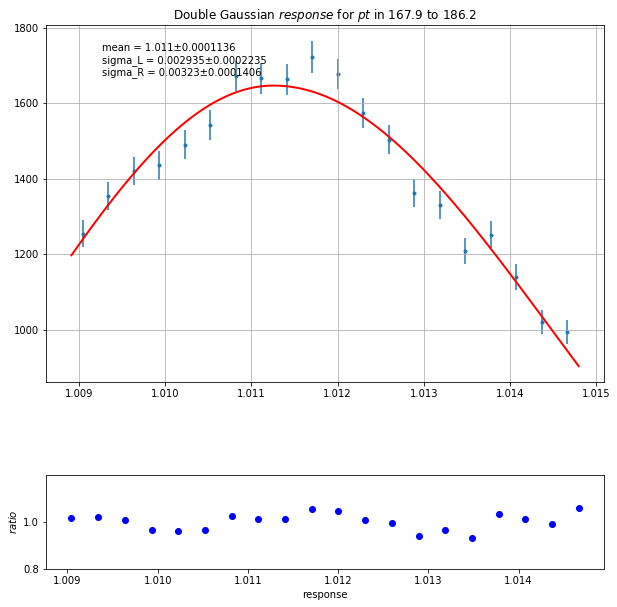

max n:78.8711922981 at 1.01138520241


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:99: SmallIntegralWarning: (1.011385202407837, -0.015331203096175389)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: In

<ArgsView of Minuit at 55873d0d71d0>
  1.01272245528
  0.00362094666732
  0.00389457552763

[9.52670207e-04 2.09185663e-03 8.40579997e-04 9.07060037e-05
 4.24081306e-05 3.54315456e-05 5.51327185e-05 0.00000000e+00
 2.23465643e-04 1.67855795e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00]


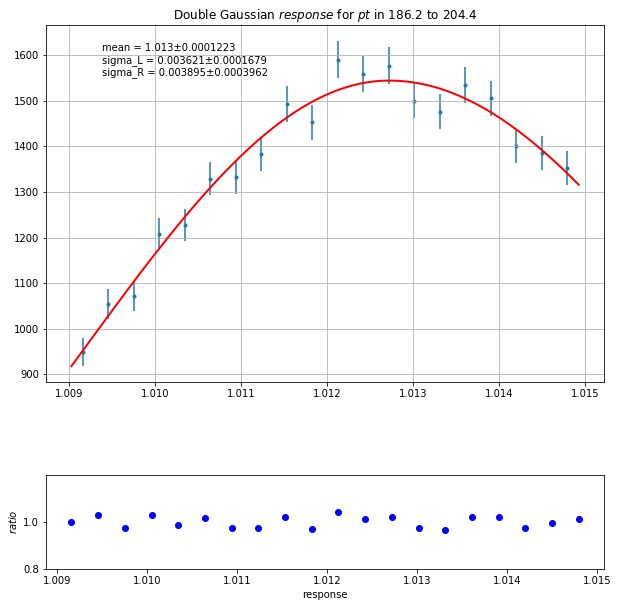

max n:75.8471059422 at 1.01379177094


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:99: SmallIntegralWarning: (1.0137917709350586, -0.0355136621891627)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: Ini

<ArgsView of Minuit at 55873e628be0>
  1.01496244489
  0.00536150841668
  0.00149075535847

[9.52670207e-04 2.09185663e-03 8.40579997e-04 9.07060037e-05
 4.24081306e-05 3.54315456e-05 5.51327185e-05 0.00000000e+00
 2.23465643e-04 1.67855795e-04 3.29316343e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00]


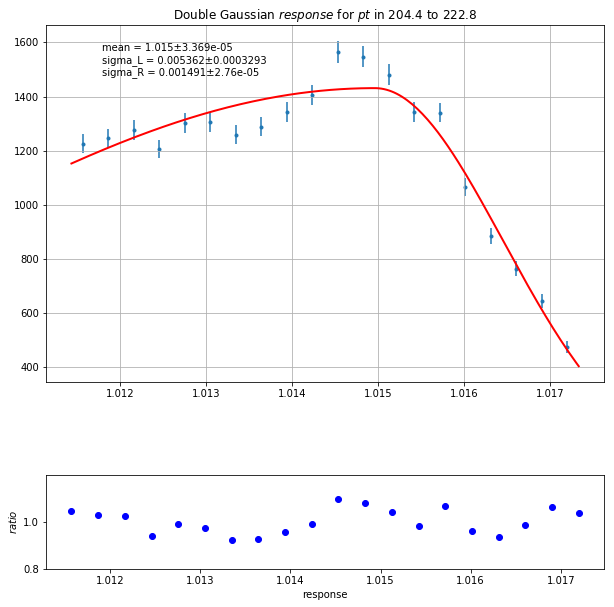

max n:69.236955594 at 1.015144068


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter sigma_R is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-pack

<ArgsView of Minuit at 55873ce0a9e0>
  1.01611716022
  0.0047453103649
  0.000918845917657

[9.52670207e-04 2.09185663e-03 8.40579997e-04 9.07060037e-05
 4.24081306e-05 3.54315456e-05 5.51327185e-05 0.00000000e+00
 2.23465643e-04 1.67855795e-04 3.29316343e-04 3.18626970e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00]


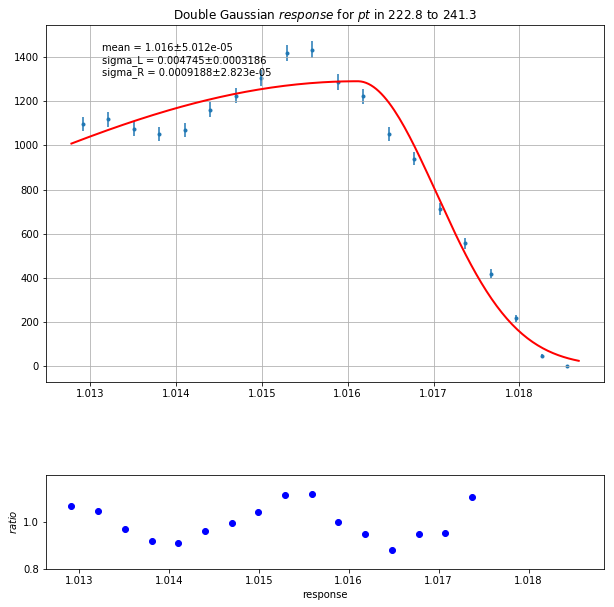

max n:56.77235722 at 1.01488258719


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:99: SmallIntegralWarning: (1.0148825871944427, -0.06899238234237612)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: In

<ArgsView of Minuit at 55873ef2fc20>
  1.01681845104
  0.00696123750902
  0.000628777199322

[9.52670207e-04 2.09185663e-03 8.40579997e-04 9.07060037e-05
 4.24081306e-05 3.54315456e-05 5.51327185e-05 0.00000000e+00
 2.23465643e-04 1.67855795e-04 3.29316343e-04 3.18626970e-04
 5.45345585e-04 0.00000000e+00 0.00000000e+00]


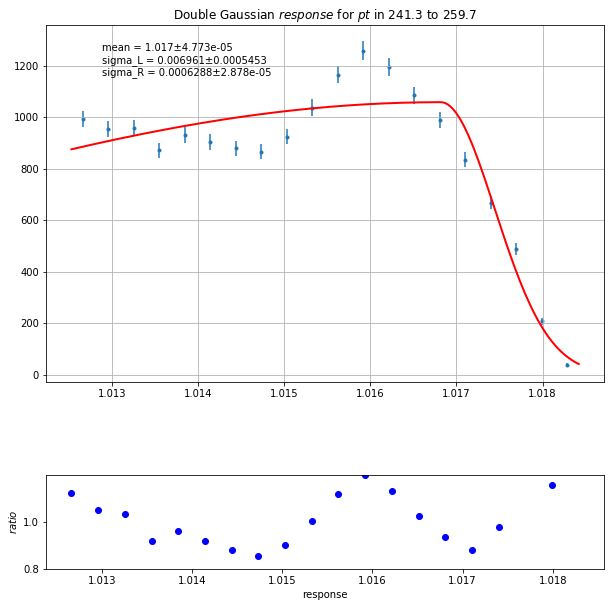

max n:47.2588480996 at 1.01622512341
None
erroor
max n:40.1170781518 at 1.01136274338


Traceback (most recent call last):
  File "<ipython-input-8-60aa10f09c99>", line 89, in <module>
    bound_gauss=[bins_gauss[n_max-2],bins_gauss[n_max+3]]#centered around the max
IndexError: index 101 is out of bounds for axis 0 with size 101
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:99: SmallIntegralWarning: (1.0113627433776855, -0.037479232423614686)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib

<ArgsView of Minuit at 55873ef3ff90>
  1.01223535277
  0.00376212582316
  0.00459049767858

[9.52670207e-04 2.09185663e-03 8.40579997e-04 9.07060037e-05
 4.24081306e-05 3.54315456e-05 5.51327185e-05 0.00000000e+00
 2.23465643e-04 1.67855795e-04 3.29316343e-04 3.18626970e-04
 5.45345585e-04 0.00000000e+00 4.24026476e-04]


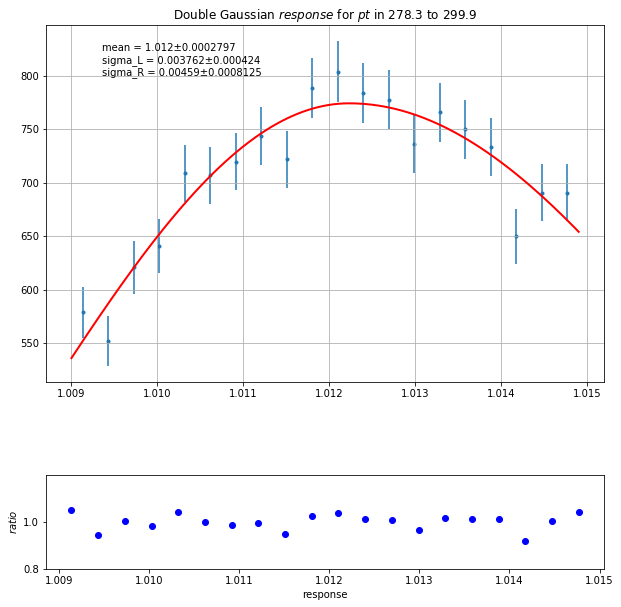

/work/kaechb/applied_EB/HuberLoss_5_EB_applied/applied_res_2019-05-02_EB.hd5
HuberLoss
max n:23.6813529172 at 0.983092987537


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter sigma_R is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-pack

<ArgsView of Minuit at 55873eb77700>
  0.983214102205
  0.0306529286778
  0.00758311591636

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


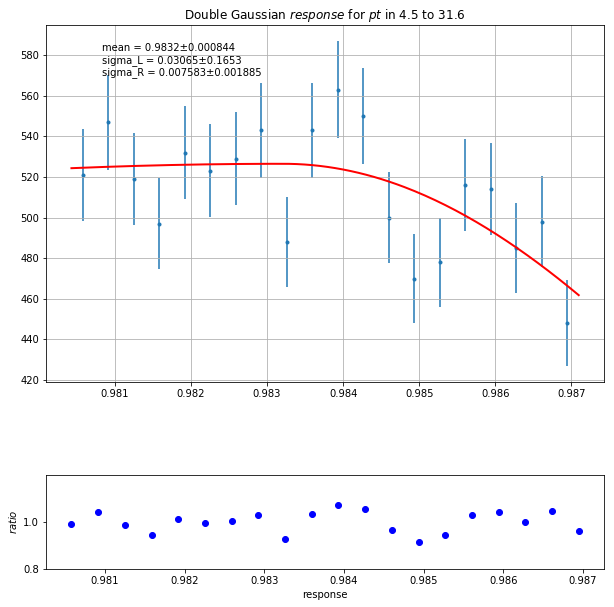

max n:51.9868888082 at 0.989588896632


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:99: SmallIntegralWarning: (0.9902464871249317, -0.0036561044796876666)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: 

<ArgsView of Minuit at 55873e7a8080>
  0.989477325412
  0.00338914757123
  0.00673590050622

[0.         0.00107365 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]


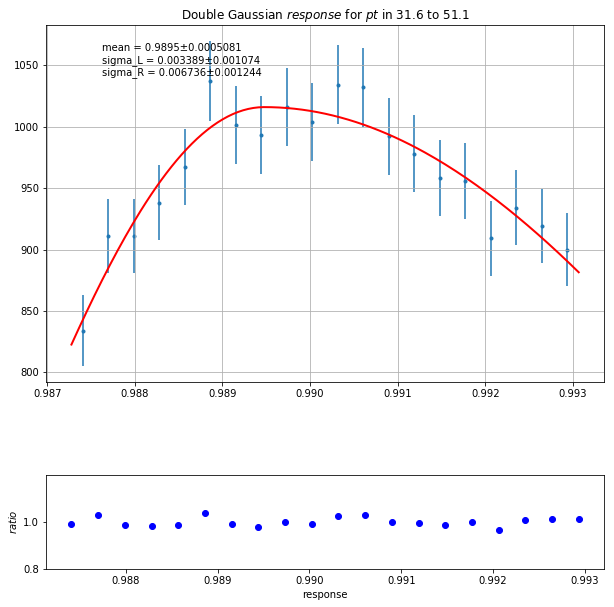

max n:65.3161503736 at 0.992646942139


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:99: SmallIntegralWarning: (0.9926469421386719, -0.02655967760465605)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: In

<ArgsView of Minuit at 55873e628be0>
  0.994043171369
  0.00520363324548
  0.00399149400795

[0.         0.00107365 0.00064593 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]


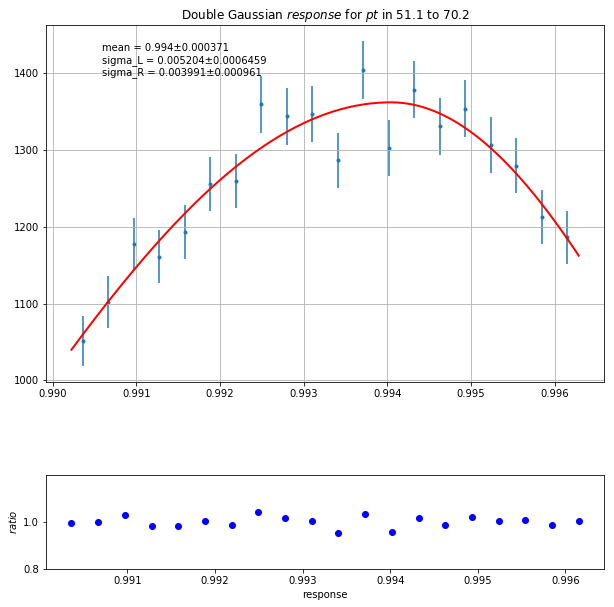

max n:80.5452668048 at 0.996060432196


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:99: SmallIntegralWarning: (0.9960604321956634, -0.04722543457959495)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: In

<ArgsView of Minuit at 55873e487c20>
  0.996704569974
  0.00354597646457
  0.0015393280682

[0.         0.00107365 0.00064593 0.00017407 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]


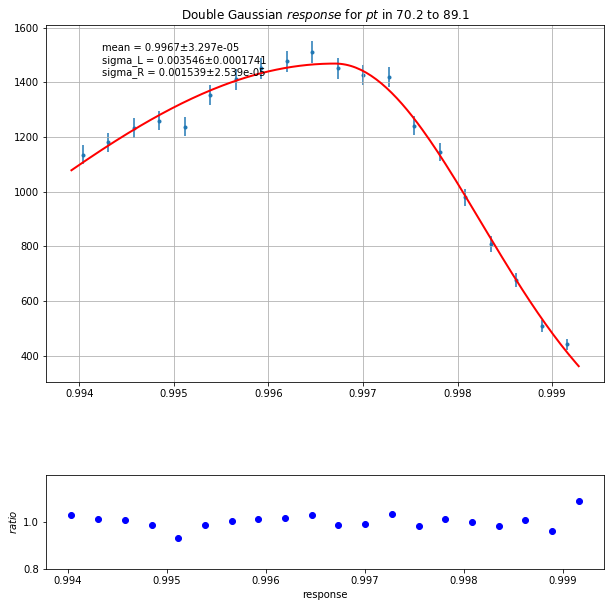

max n:92.0894177708 at 0.99663361311


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:99: SmallIntegralWarning: (0.9966336131095886, -0.061488597696969974)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: I

<ArgsView of Minuit at 55873e603690>
  0.997350819215
  0.00326690288906
  0.00129800318308

[0.         0.00107365 0.00064593 0.00017407 0.00012214 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]


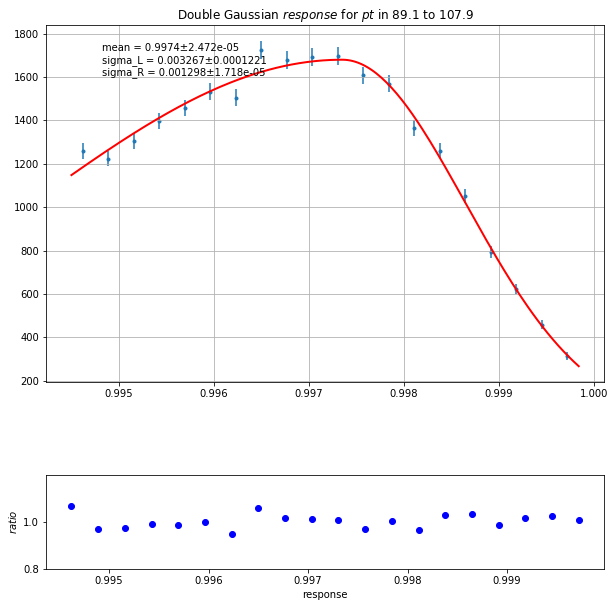

max n:98.1148177667 at 0.99661629796


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:99: SmallIntegralWarning: (0.9966162979602814, -0.04703127730365364)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: In

<ArgsView of Minuit at 55873c806d60>
  0.997491851737
  0.00321242233136
  0.00138072570066

[0.         0.00107365 0.00064593 0.00017407 0.00012214 0.00010323
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]


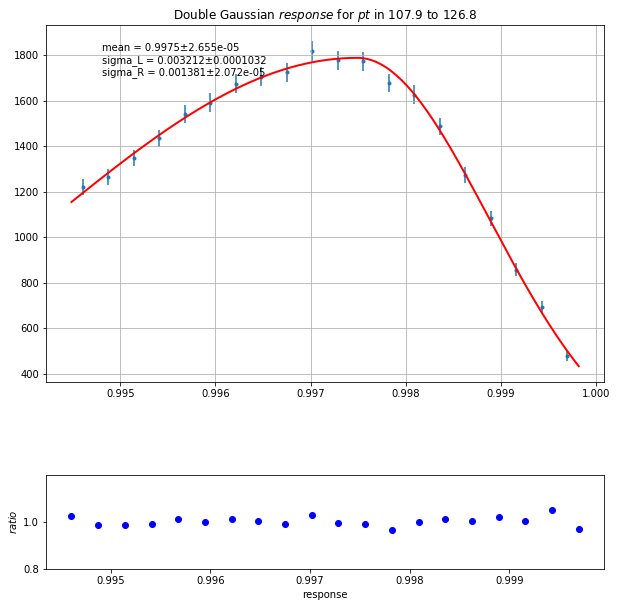

max n:104.418858455 at 0.996419048309


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:99: SmallIntegralWarning: (0.9964190483093261, -0.03604379782077709)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: In

<ArgsView of Minuit at 55873c893f30>
  0.99733135837
  0.00306821611093
  0.00166001463584

[0.         0.00107365 0.00064593 0.00017407 0.00012214 0.00010323
 0.00012676 0.         0.         0.         0.         0.
 0.         0.         0.        ]


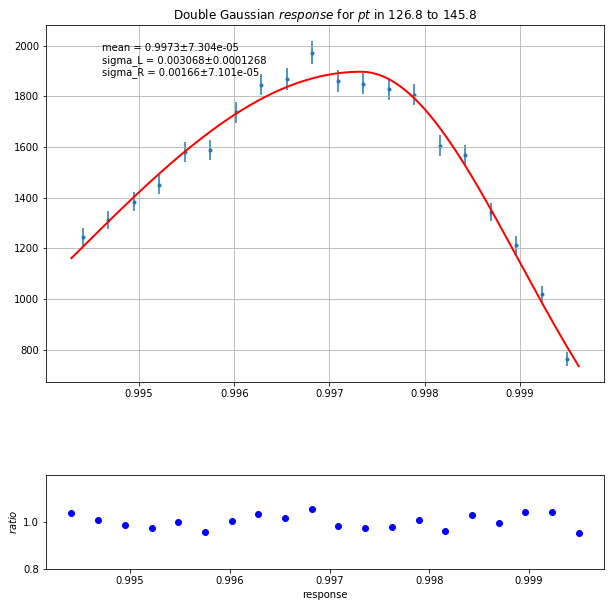

max n:115.229786798 at 0.996460711956


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:99: SmallIntegralWarning: (0.9964607119560241, -0.042065145699442766)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: I

<ArgsView of Minuit at 55873cce2020>
  0.996995054277
  0.00253825686817
  0.00176565117001

[0.00000000e+00 1.07364825e-03 6.45934181e-04 1.74070459e-04
 1.22143525e-04 1.03228021e-04 1.26764647e-04 7.23850362e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00]


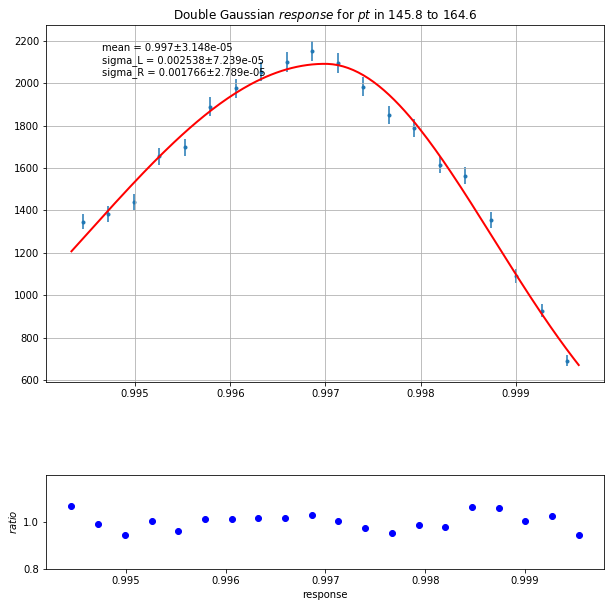

max n:125.817541387 at 0.996392601132


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:99: SmallIntegralWarning: (0.9963926011323929, -0.05886003679193384)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: In

<ArgsView of Minuit at 55873ef6a960>
  0.996811808649
  0.00227115279649
  0.0017263770816

[0.00000000e+00 1.07364825e-03 6.45934181e-04 1.74070459e-04
 1.22143525e-04 1.03228021e-04 1.26764647e-04 7.23850362e-05
 5.55877905e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00]


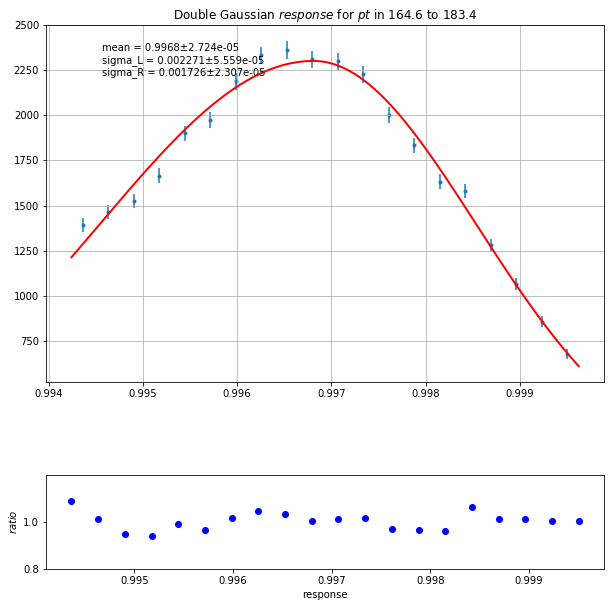

max n:138.778123569 at 0.995929712057


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:99: SmallIntegralWarning: (0.9959297120571137, -0.05495082924048053)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: In

<ArgsView of Minuit at 55873e857030>
  0.996764312327
  0.00233918628114
  0.00153679045363

[0.00000000e+00 1.07364825e-03 6.45934181e-04 1.74070459e-04
 1.22143525e-04 1.03228021e-04 1.26764647e-04 7.23850362e-05
 5.55877905e-05 5.56751519e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00]


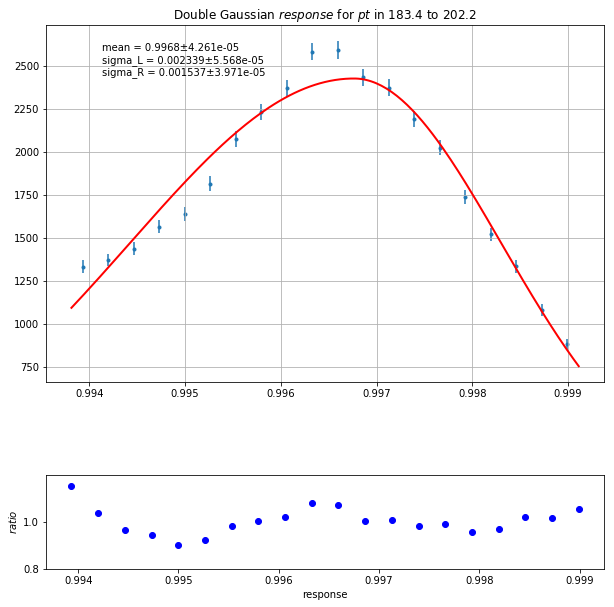

max n:136.073374232 at 0.995599367023


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:99: SmallIntegralWarning: (0.9955993670225144, -0.06627386909792549)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: In

<ArgsView of Minuit at 55873d1d4a20>
  0.996874811255
  0.0026424309059
  0.00128227826129

[0.00000000e+00 1.07364825e-03 6.45934181e-04 1.74070459e-04
 1.22143525e-04 1.03228021e-04 1.26764647e-04 7.23850362e-05
 5.55877905e-05 5.56751519e-05 4.29361788e-05 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00]


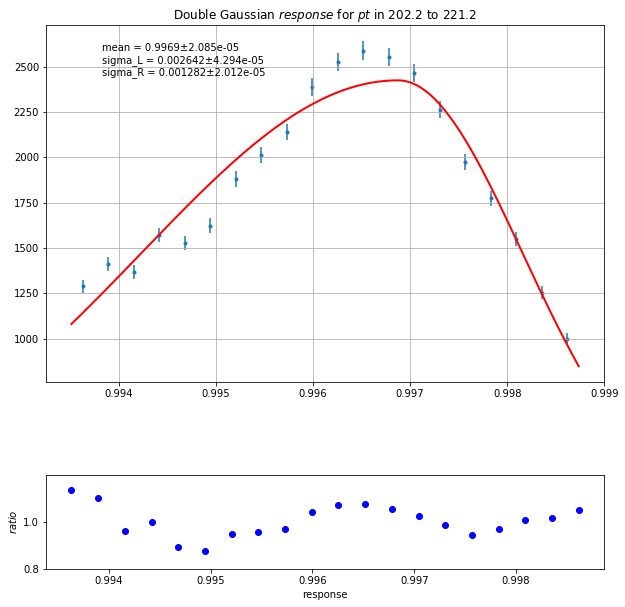

max n:135.423089461 at 0.996572036743


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:99: SmallIntegralWarning: (0.9965720367431641, -0.008504390994830621)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: I

<ArgsView of Minuit at 55873eab3ee0>
  0.996594378433
  0.00187595036713
  0.00141678999989

[0.00000000e+00 1.07364825e-03 6.45934181e-04 1.74070459e-04
 1.22143525e-04 1.03228021e-04 1.26764647e-04 7.23850362e-05
 5.55877905e-05 5.56751519e-05 4.29361788e-05 5.52268221e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00]


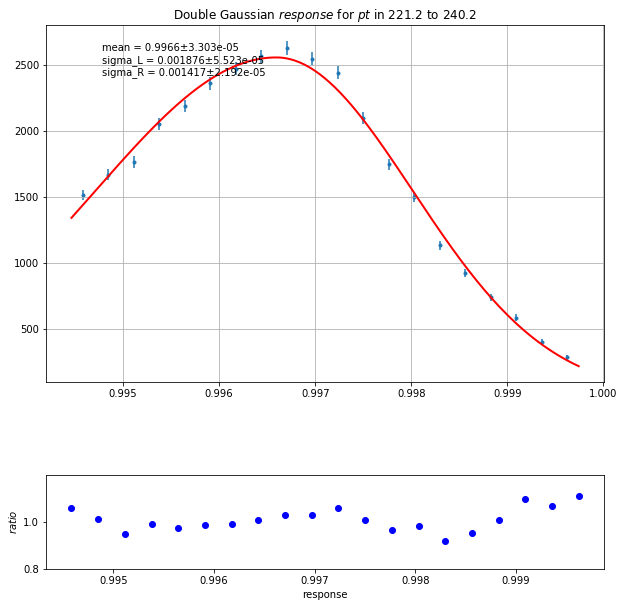

max n:141.339351298 at 0.995957019925


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:99: SmallIntegralWarning: (0.9959570199251175, -0.08649434924317266)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: In

<ArgsView of Minuit at 55873b766990>
  0.996739924092
  0.0025297564036
  0.00121242527228

[0.00000000e+00 1.07364825e-03 6.45934181e-04 1.74070459e-04
 1.22143525e-04 1.03228021e-04 1.26764647e-04 7.23850362e-05
 5.55877905e-05 5.56751519e-05 4.29361788e-05 5.52268221e-05
 5.01994061e-05 0.00000000e+00 0.00000000e+00]


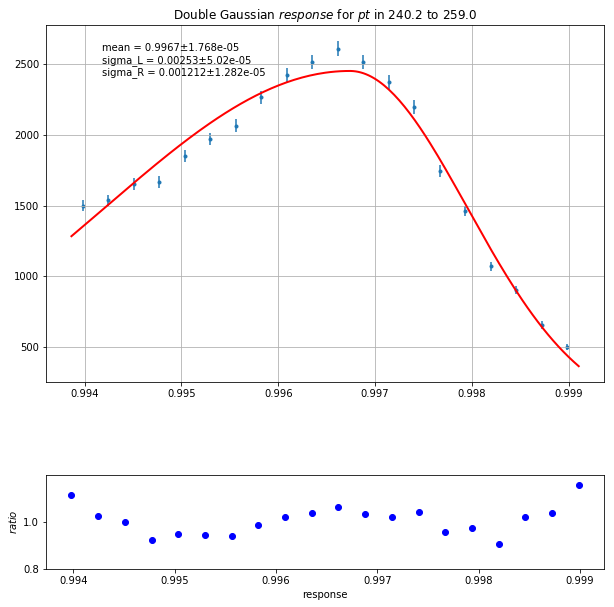

max n:134.261155485 at 0.996261546612


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:99: SmallIntegralWarning: (0.9962615466117859, -0.005480790867013717)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: I

<ArgsView of Minuit at 55873e6062c0>
  0.99667484247
  0.00238388585587
  0.00118051148094

[0.00000000e+00 1.07364825e-03 6.45934181e-04 1.74070459e-04
 1.22143525e-04 1.03228021e-04 1.26764647e-04 7.23850362e-05
 5.55877905e-05 5.56751519e-05 4.29361788e-05 5.52268221e-05
 5.01994061e-05 6.96675465e-05 0.00000000e+00]


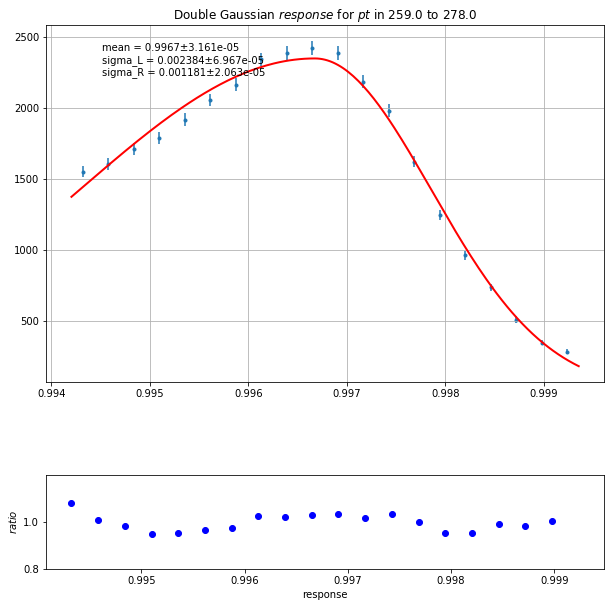

max n:131.951703533 at 0.996094608307


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:99: SmallIntegralWarning: (0.9960946083068848, -0.003790178221490942)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: I

<ArgsView of Minuit at 55873d434940>
  0.996776555971
  0.00277845736493
  0.00106012149469

[0.00000000e+00 1.07364825e-03 6.45934181e-04 1.74070459e-04
 1.22143525e-04 1.03228021e-04 1.26764647e-04 7.23850362e-05
 5.55877905e-05 5.56751519e-05 4.29361788e-05 5.52268221e-05
 5.01994061e-05 6.96675465e-05 7.03807749e-05]


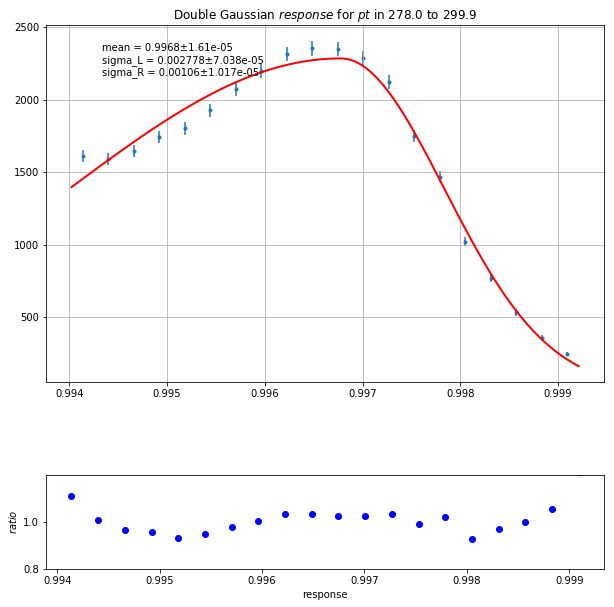

/work/kaechb/applied_EB/HuberLoss_2_EB_applied/applied_res_2019-05-02_EB.hd5
HuberLoss
max n:29.3979952938 at 0.978409210443


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:99: SmallIntegralWarning: (1.247888549983242, -0.5166969624242119)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: Init

<ArgsView of Minuit at 55873b6f84e0>
  0.981631646616
  0.00960462715063
  0.000845644805265

[0.00133211 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]


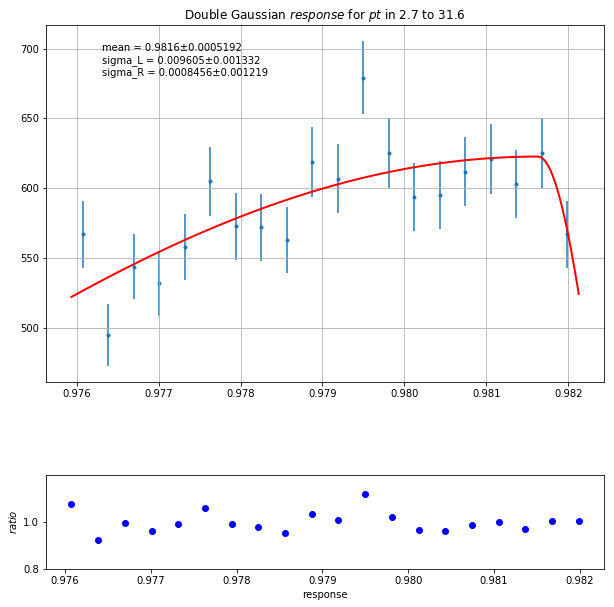

max n:48.6627737794 at 0.987599975467


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter sigma_R is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-pack

<ArgsView of Minuit at 55873c967aa0>
  0.988200637407
  0.00571173216608
  0.00679328597822

[0.00133211 0.00145118 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]


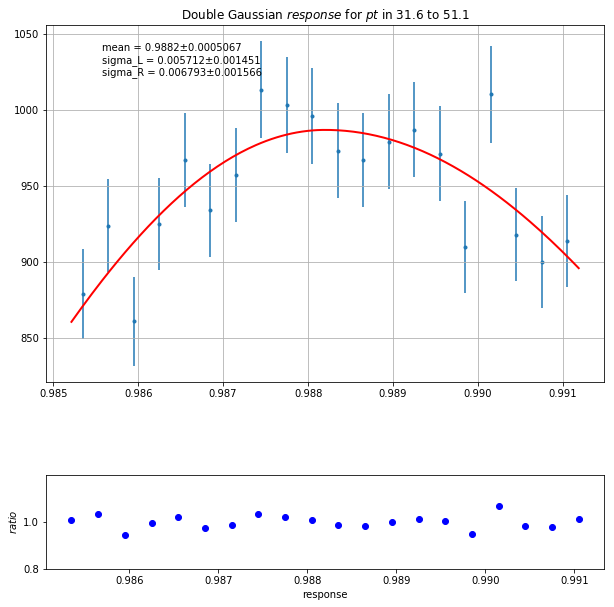

max n:64.5470997443 at 0.991683328152


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:99: SmallIntegralWarning: (0.9916833281517029, -0.00652472159331538)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: In

<ArgsView of Minuit at 55873d5221c0>
  0.992245610326
  0.00442542447449
  0.00302276258936

[0.00133211 0.00145118 0.00060213 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]


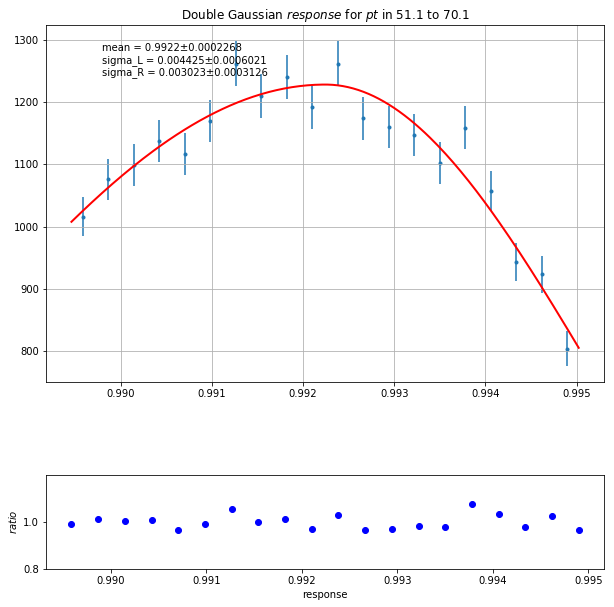

max n:74.2790685344 at 0.992700059414


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:99: SmallIntegralWarning: (0.9927000594139099, -0.024182831043747716)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: I

<ArgsView of Minuit at 55873e6062c0>
  0.994105841594
  0.00463795920939
  0.00228363395951

[0.00133211 0.00145118 0.00060213 0.00039912 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]


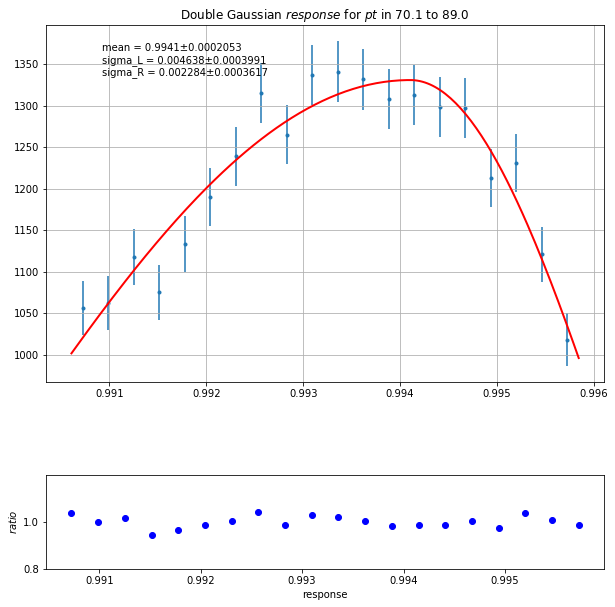

max n:82.1176464649 at 0.994577963948


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:98: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:99: SmallIntegralWarning: (0.9945779639482498, -0.032765955947633194)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:119: I

<ArgsView of Minuit at 55873b6b4c70>
  0.995138225991
  0.00456611649269
  0.00195649820339

[0.00133211 0.00145118 0.00060213 0.00039912 0.00038584 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]


In [ ]:
parent_dir="/work/kaechb/applied_EB/"

matplotlib.rcParams['figure.figsize'] = [10, 10]
inp_dir=parent_dir
bins_gaussian_amount=100
bins_double_gaussian_amount=20
amountbins_column=15
debug_fit=0
debug_fit_gauss=0
amountbins=15

for column in ['pt','rhoValue','scEta']:#

    profile_x=[]
    profile_y=[]
    profile_ef=[]
    profile_down=[]
    profile_up=[]
    profile_sigma_l=[]
    profile_sigma_l_err=[]

    for k in range(0,len(names)):


        if names[k].find("OneTail")>-1:
                end="HuberLossOneTail"
                delta=names[k].split("_")[1]

        elif names[k].find("Huber")>-1:
                end="HuberLoss"
                delta=names[k].split("_")[1]
        elif names[k].find("mse")>-1:
                end="mse"
                delta=names[k].split("_")[2]
        plot_out_dir="/work/kaechb/"+end+"_"+delta+"/" 

        if not os.path.exists(plot_out_dir):
            os.makedirs(plot_out_dir)
        inp_file=names[k]
        original_df=io.read_data('%s%s'%(inp_dir,inp_file),columns=None)
        print('%s%s'%(inp_dir,inp_file))
        print(end)

        lower_bound=0.9
        upper_bound=1.1

        y_plot=np.zeros(amountbins)
        x_plot=np.zeros(amountbins)
        y_err_fit=np.zeros(amountbins)
        sigma_l=np.zeros(amountbins)
        sigma_l_err=np.zeros(amountbins)
        y_err_L_sigma=np.zeros(amountbins)
        y_err_R_sigma=np.zeros(amountbins)
        df=original_df.copy()


        df.loc[:,'response']=np.reciprocal(df.loc[:,'response'].values)
        df=df[df['response']>lower_bound]
        df=df[df['response']<upper_bound]
        if k<len(names):
            df.loc[:,'response_NN_'+end]=np.reciprocal(df.loc[:,'response_NN_'+end].values)
            df=df[df['response_NN_'+end]>lower_bound]
            df=df[df['response_NN_'+end]<upper_bound]
        df=df[df['pt']>0]
        df=df[df['pt']<300]
#        df.loc[:,column[:2]]=df[abs(df[column[:2]]-df[column[:2]].mean())<3*df[column[:2]].std()][column[:2]] #outlier fuck up binning otherwise
        notused,bins=pd.qcut(df[column],amountbins_column, retbins=True)   

        for i in range(0,len(bins)-1):
            try:
                ##selecting data in bin
                df_temp=df[df[column] >=bins[i]]

                df_temp=df_temp[df_temp[column]<=bins[i+1]]
                if k<len(names):
                    data=df_temp.loc[:,'response_NN_'+end].astype(float).values

                else:
                    data=df_temp.loc[:,'response'].astype(float).values 


                n,bins_gauss,patches=plt.hist(data,bins=bins_gaussian_amount,density=True)
                plt.close()
                if np.sum(n) ==0:
                    print("sum is zero!")
                    continue
                n_max=np.argmax(n)
                print("max n:{} at {}".format(np.max(n),bins_gauss[n_max]))
                bound_gauss=[bins_gauss[n_max-2],bins_gauss[n_max+3]]#centered around the max
                normalized_gaussian = probfit.Normalized(probfit.gaussian, bound_gauss)
                normalized_doublegaussian = probfit.Normalized(probfit.pdf.doublegaussian, bound_gauss)
                binned_likelihood_gauss = probfit.BinnedLH(normalized_gaussian, data, 
                                         bins=bins_double_gaussian_amount, bound=bound_gauss)

                pars_gauss = dict(mean  = bins_gauss[np.argmax(n)],
                                  sigma = 0.05,
                                   )
                minuit = iminuit.Minuit(binned_likelihood_gauss,print_level=debug_fit_gauss, **pars_gauss)
                minuit.migrad()  
                binned_likelihood_gauss.draw(minuit,nfbins=bins_double_gaussian_amount)
                plt.close()




                mean_gauss  = minuit.values[0]
                sigma_gauss = minuit.values[1]
                if sigma_gauss==0:
                    sigma_gauss==0.05
                pars_dg = dict(mean  = mean_gauss,  
                               sigma_L = sigma_gauss,
                               sigma_R =sigma_gauss,
                               limit_sigma_L=(0.001,0.1),
                               limit_sigma_R=(0.001,0.3),
                               )
                binned_likelihood_dg   = probfit.BinnedLH(normalized_doublegaussian, data,
                                bins=bins_double_gaussian_amount, bound=bound_gauss)

                minuit = iminuit.Minuit(binned_likelihood_dg,print_level=debug_fit, **pars_dg)
                minuit.migrad( ) 
                binned_likelihood_dg.draw(minuit)
                plt.close()

                pars =dict(minuit.values)

                #pars['limit_mean']=(0.986,1.01)
                minuit = iminuit.Minuit(binned_likelihood_dg,print_level=debug_fit_gauss, **pars)
                minuit.migrad()  
                coeff=minuit.args
                display(coeff)

                ax=plt.subplot2grid((6,3),(0,0), rowspan=4,colspan=4)   
                (data_edges, datay), (errorp, errorm), (total_pdf_x, total_pdf_y),parts = \
                binned_likelihood_dg.draw(minuit,parmloc=((0.1,0.95)),nfbins=10*bins_double_gaussian_amount)

                plt.title("Double Gaussian $response$ for ${}$ in {} to {}".format(column,int(10*bins[i])/10.,int(10*bins[i+1])/10.))
                data_edges=(data_edges[1:]+data_edges[:-1])/2
                fit_y=np.zeros(len(datay))
                x_plot[i]=df_temp[column].values[np.argmin(df_temp['response'].values-coeff[0])]
                y_plot[i]=coeff[0]
                y_err_fit[i]+=minuit.errors[0]
                y_err_L_sigma[i]+=coeff[1]
                sigma_l_err[i]+=minuit.errors[1]
                if sigma_l_err[i]>.05:
                    sigma_l_err[i]=0
                print(sigma_l_err)
                sigma_l[i]+=coeff[1]
                y_err_R_sigma[i]+=coeff[2]
                for kill in range(0,len(datay)):
                    fit_y[kill]=total_pdf_y[np.argmin(abs(total_pdf_x - data_edges[kill]))]
                ratio=datay/fit_y
                plt.subplot2grid((5,3),(4,0),rowspan=2,colspan=4).set_yticks([0.8,1])
                plt.plot(data_edges,ratio,'bo')


                plt.ylabel(r"$ratio$")
                plt.xlabel("response")
                plt.ylim([0.8,1.2])
                plt.savefig(plot_out_dir+"/{}__{}_{}_{}".format(column,i,end,delta)) 

                plt.show()

            except Exception as e:
                print(traceback.print_exc())
                print ("erroor")

        profile_x.append(x_plot)
        profile_y.append(y_plot)
        profile_ef.append(y_err_fit)
        profile_down.append(y_err_L_sigma)
        profile_up.append(y_err_R_sigma)
        profile_sigma_l.append(sigma_l)
        profile_sigma_l_err.append(sigma_l_err)



    fig,ax=plt.subplots()
    ax.set_ylim([0.95,1.03])
    ax.set_title("Profile $response$ vs ${}$, Fit error".format(column))
    ax.set_ylabel(r"$response$")
    ax.set_xlabel(r"${}$".format(column))
    for index in range(0,len(names)):

            if names[index].find("OneTail")>-1:

                    end="HuberLossOneTail"
                    delta=names[index].split("_")[1]
                    end=end+delta

            elif names[index].find("Huber")>-1:
                    end="HuberLoss"
                    delta=names[index].split("_")[1]
                    end=end+delta
            elif names[index].find("mse")>-1:
                end="mse"
                delta=names[index].split("_")[2]
                end=end+delta
            ax.errorbar(profile_x[index],profile_y[index],yerr=profile_ef[index],fmt='.',label=end)  
    ax.legend()
    fig.savefig(plot_out_dir+"Fit_Error_{}response_vs_{}".format(end,column))
    fig.show()

    fig,ax=plt.subplots()

    ax.set_title("Profile $\sigma_L$ vs ${}$".format(column))
    ax.set_ylabel(r"$response$")
    ax.set_xlabel(r"${}$".format(column))
    for index in range(0,len(names)):
        print(names[index])
        if names[index].find("OneTail")>-1:

                end="HuberLossOneTail"
                delta=names[index].split("_")[1]
                end=end+delta

        elif names[index].find("Huber")>-1:
                end="HuberLoss"
                delta=names[index].split("_")[1]
                end=end+delta
        elif names[index].find("mse")>-1:
                end="mse"
                delta=names[index].split("_")[2]
                end=end+delta
        ax.errorbar(profile_x[index],profile_sigma_l[index],yerr=list(profile_sigma_l_err[index]),fmt='.',label=end)  
    ax.legend()
    #fig.savefig(plot_out_dir+"Sigma_L_{}response_vs_{}".format(end,column))
    fig.show()






In [7]:

names=[]
for dire in os.listdir(parent_dir):
      
    #if  os.path.isdir("/work/kaechb/"+dire):
        for file in os.listdir(parent_dir+dire):#+"/"+dire
        #for file in os.listdir(sys.argv[1]):
            if file.find('.hd')!=-1 and file.find('applied')!=-1 :
               # input_dir.append(parent_dir)#+dire+"/"][0]
                
                names.append(dire+"/"+file)
print(names)


['HuberLossOneTail_2_EB_applied/applied_res_2019-05-02_EB.hd5', 'HuberLossOneTail_5_EB_applied/applied_res_2019-05-02_EB.hd5', 'HuberLoss_5_EB_applied/applied_res_2019-05-02_EB.hd5', 'HuberLoss_2_EB_applied/applied_res_2019-05-02_EB.hd5', 'HuberLossOneTail_1_EB_applied/applied_res_2019-05-02_EB.hd5', 'mse_EB_1_applied/applied_res_2019-05-02_EB.hd5', 'HuberLoss_1_EB_applied/applied_res_2019-05-02_EB.hd5']


In [ ]:
def plot_response(input_dir,names,out_dir):
   
        matplotlib.rcParams['figure.figsize'] = [10, 10]
        fig1_no_Tail,ax1_no_Tail=plt.subplots()
        cycol = cycle('bgrcmk')


        fig3_no_Tail,ax3_no_Tail=plt.subplots()
        fig1_Tail,ax1_tail=plt.subplots()


        fig3_Tail,ax3_tail=plt.subplots()

        counter=0
        
        for i in range(0,len(input_dir)):
            
            if names[i].find("OneTail")>0:
                    end="HuberLossOneTail"
                    lbl="delta"+names[i][14]
                    fig1=fig1_Tail
                    ax1=ax1_tail
                    fig3=fig3_Tail
                    ax3=ax3_tail


                    
            else:
                    end="HuberLoss"
                    lbl="delta"+names[i][14]
                    fig1=fig1_no_Tail
                    ax1=ax1_no_Tail
                    fig3=fig3_no_Tail
                    ax3=ax3_no_Tail

            inp_dir=input_dir[i]
            inp_file=names[i]

            data = io.read_data('%s%s'%(inp_dir,inp_file),columns=None)




            print("data read: ",end)
            y = (data['genPt']/data['pt']).values.reshape(-1,1)
            X_pt = (data['pt']).values.reshape(-1,1)
            X_eta = (data['scEta']).values.reshape(-1,1)
            response = (data['scRawEnergy']*data['response']).values.reshape(-1,1)
            response_NN = (data['scRawEnergy']*data['response_NN_'+end]).values.reshape(-1,1)
            gen_energy = (data['genEnergy']).values.reshape(-1,1)

            raw_energy = (data['scRawEnergy']).values.reshape(-1,1)
            raw=(data['scRawEnergy']/data['genEnergy']).values.reshape(-1,1)
            ax1.hist(response_NN,bins=100,label="response"+end+lbl+ind,range=(0,20000),density=True,histtype=u'step')
            if counter==0:
                ax1_no_Tail.hist(response,bins=100,label='BDT',range=(0,20000),density=True,histtype=u'step')
                ax3_no_Tail.hist(raw,bins=1000,label='raw',range=(0.8,1.2),histtype=u'step')
                ax3_no_Tail.hist(gen_energy/response,bins=1000,range=(0.8,1.2),log=False,label='BDT',histtype=u'step');
                ax1_tail.hist(response,bins=100,label='BDT',range=(0,20000),density=True,histtype=u'step')
                ax3_tail.hist(raw,bins=1000,label='raw',range=(0.8,1.2),histtype=u'step')
                ax3_tail.hist(gen_energy/response,bins=1000,range=(0.8,1.2),log=False,label='BDT',histtype=u'step');
                counter+=1


            ax3.hist(gen_energy/response_NN,bins=1000,range=(0.8,1.2),
                     log=False,label='corrected_'+end+lbl+ind,histtype=u'step');



        ax3_no_Tail.legend(loc='upper right');
        ax1_no_Tail.legend(loc='upper right')
        ax1_no_Tail.set_title("histogramm scRawEnergy*response  Huber pt {}".format(ind))
        ax3_no_Tail.set_title("Histogram gen_energy/response Huber pt {}".format(ind))
        fig1_no_Tail.show()
        fig3_no_Tail.show()
        fig3_no_Tail.savefig("{}/historical_comparision{}".format(out_dir,ind))
        fig1_no_Tail.savefig("{}/response{}".format(out_dir,ind))
        ax3_tail.legend(loc='upper right');
        ax1_tail.legend(loc='upper right')
        ax1_tail.set_title("histogramm scRawEnergy*response  HuberOneTail pt {}".format(ind))
        ax3_tail.set_title("Histogram gen_energy/response HuberOneTail pt {}".format(ind))
        fig1_Tail.show()
        fig3_Tail.show()
